## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from statsmodels.graphics.tsaplots import plot_pacf
import random
import math
import mlflow
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import joblib
import os
from datetime import datetime
import json

In [2]:
## SKIP TO FEATURE ENGINEERING IF ALREADY DOWNLOADED
for year in range(2016, 2026):
    delimiter = ';' if year > 2021 else ','
    file_path = f'../data/histo_cotation_{year}.csv'
    globals()[f'data_{year}'] = pd.read_csv(file_path, delimiter=delimiter, engine='python')
    print(f"Loaded data_{year}: {globals()[f'data_{year}'].shape}")

Loaded data_2016: (126065, 12)
Loaded data_2017: (133687, 11)
Loaded data_2018: (74594, 15)
Loaded data_2019: (77588, 14)
Loaded data_2020: (140415, 12)
Loaded data_2021: (137372, 11)
Loaded data_2022: (83939, 11)
Loaded data_2023: (147209, 11)
Loaded data_2024: (145381, 11)
Loaded data_2025: (142853, 11)


In [3]:
# Get all dataframes and their column names
dataframes = {f'data_{year}': globals()[f'data_{year}'] for year in range(2016, 2026)}

for name, df in dataframes.items():
    print(f"{name} has columns: {df.columns.tolist()}")

data_2016 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX', 'IND_RES']
data_2017 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX    IND_RES']
data_2018 has columns: ['SEANCE', 'C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX', 'I']
data_2019 has columns: ['SEANCE', 'C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX I']
data_2020 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX', 'IND_RES']
data_2021 has columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEU

In [4]:
display(globals()['data_2016']['IND_RES'].unique())
display(globals()['data_2018']['I'].unique())
globals()['data_2020']['IND_RES'].unique()

array([nan, 'H', 'B'], dtype=object)

array([nan, '+', '-'], dtype=object)

array([nan, 'B', 'H'], dtype=object)

In [5]:
# Clean data_2017 before normalization
# Split the 'CAPITAUX    IND_RES' column
globals()['data_2017']['CAPITAUX    IND_RES'] = globals()['data_2017']['CAPITAUX    IND_RES'].astype(str)

# Extract only numeric part for CAPITAUX (remove any non-numeric characters at the end)
globals()['data_2017']['CAPITAUX'] = globals()['data_2017']['CAPITAUX    IND_RES'].str.extract(r'([\d\.,]+)', expand=False)

# Convert CAPITAUX to numeric, handling any conversion errors
globals()['data_2017']['CAPITAUX'] = pd.to_numeric(globals()['data_2017']['CAPITAUX'].str.replace(',', '.'), errors='coerce')

# Extract non-numeric part for IND_RES (anything after the numbers)
globals()['data_2017']['IND_RES'] = globals()['data_2017']['CAPITAUX    IND_RES'].str.replace(r'^[\d\.,\s]+', '', regex=True)

# Drop the original combined column
globals()['data_2017'] = globals()['data_2017'].drop(columns=['CAPITAUX    IND_RES'])

print(f"Cleaned data_2017 columns: {globals()['data_2017'].columns.tolist()}")
print(f"Sample CAPITAUX values: {globals()['data_2017']['CAPITAUX'].head()}")
print(f"Sample IND_RES values: {globals()['data_2017']['IND_RES'].head()}")


Cleaned data_2017 columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX', 'IND_RES']
Sample CAPITAUX values: 0    29189.00
1    72703.57
2     2790.40
3    46802.41
4    51625.32
Name: CAPITAUX, dtype: float64
Sample IND_RES values: 0    
1    
2    
3    
4    
Name: IND_RES, dtype: object


In [6]:
# Clean data_2019 before normalization
# Split the 'CAPITAUX    I' column
globals()['data_2019']['CAPITAUX I'] = globals()['data_2019']['CAPITAUX I'].astype(str)

# Extract only numeric part for CAPITAUX (remove any non-numeric characters at the end)
globals()['data_2019']['CAPITAUX'] = globals()['data_2019']['CAPITAUX I'].str.extract(r'([\d\.,]+)', expand=False)

# Convert CAPITAUX to numeric, handling any conversion errors
globals()['data_2019']['CAPITAUX'] = pd.to_numeric(globals()['data_2019']['CAPITAUX'].str.replace(',', '.'), errors='coerce')

# Extract non-numeric part for IND_RES (anything after the numbers)
globals()['data_2019']['IND_RES'] = globals()['data_2019']['CAPITAUX I'].str.replace(r'^[\d\.,\s]+', '', regex=True)

# Drop the original combined column
globals()['data_2019'] = globals()['data_2019'].drop(columns=['CAPITAUX I'])

print(f"Cleaned data_2019 columns: {globals()['data_2019'].columns.tolist()}")
print(f"Sample CAPITAUX values: {globals()['data_2019']['CAPITAUX'].head()}")
print(f"Sample IND_RES values: {globals()['data_2019']['IND_RES'].head()}")


Cleaned data_2019 columns: ['SEANCE', 'C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX', 'IND_RES']
Sample CAPITAUX values: 0     20620.80
1      7240.06
2     15924.09
3    118592.33
4      1948.72
Name: CAPITAUX, dtype: float64
Sample IND_RES values: 0    
1    
2    
3    
4    
Name: IND_RES, dtype: object


In [7]:
def normalize_columns(df, year):
    """Normalize column names and strip whitespace"""
    # Strip whitespace from all column names
    df.columns = df.columns.str.strip()
    
    # Create column mapping based on year
    if year in [2018, 2019]:
        column_mapping = {
            'C_GR_RLC': 'GROUPE',
            'CODE_VAL': 'CODE',
            'LIB_VAL': 'VALEUR',
            'NB_TRAN': 'NB_TRANSACTION'
        }
    else:
        column_mapping = {}
    
    # Rename columns
    df = df.rename(columns=column_mapping)
    
    # Select only common columns
    common_columns = [
        'SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 
        'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 
        'NB_TRANSACTION', 'CAPITAUX'
    ]
    
    # Keep only columns that exist
    available_columns = [col for col in common_columns if col in df.columns]
    
    return df[available_columns]

In [8]:
# Apply normalization to all dataframes
for year in range(2016, 2026):
    globals()[f'data_{year}'] = normalize_columns(globals()[f'data_{year}'], year)
    print(f"Normalized data_{year}: {globals()[f'data_{year}'].columns.tolist()}")

Normalized data_2016: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2017: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2018: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2019: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2020: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2021: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
Normalized data_2022: ['SEANCE', '

In [9]:
# Clean data_2018 and data_2019 - convert comma decimals to dots and make numeric
for year in [2018, 2019]:
    df = globals()[f'data_{year}']
    
    # List of columns that should be numeric
    numeric_columns = ['COURS_REF', 'COURS_VEILLE', 'OUVERTURE', 'DERNIER_COURS', 
                      'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 
                      'NB_TRAN', 'CAPITAUX']
    
    # Convert columns: replace comma with dot and convert to numeric
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '.').str.replace(' ', '')
    
    globals()[f'data_{year}'] = df
    print(f"Cleaned data_{year} numeric columns")
    print(f"Sample values: {df[['OUVERTURE', 'CLOTURE', 'CAPITAUX']].head()}")
    print()

Cleaned data_2018 numeric columns
Sample values:   OUVERTURE CLOTURE   CAPITAUX
0      5.25    5.39    15635.5
1     24.38      24      36918
2      6.27     6.1  219020.05
3         0       9        nan
4      4.15    4.18    15465.9

Cleaned data_2019 numeric columns
Sample values:   OUVERTURE CLOTURE   CAPITAUX
0       4.8     4.8    20620.8
1      27.8   27.75    7240.06
2      6.27    6.28   15924.09
3      7.79    8.02  118592.33
4      3.76    3.65    1948.72



In [10]:
# Combine all dataframes
all_data = pd.concat([globals()[f'data_{year}'] for year in range(2016, 2026)], ignore_index=True)
print(f"\nCombined dataset shape: {all_data.shape}")


Combined dataset shape: (1209103, 11)


In [11]:
dataset = all_data.copy()
display(dataset.head(3))
display(dataset.tail(3))

,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
0,04/01/2016,11,100010,MONOPRIX,14.19,13.9,13.77,14.19,2008,21,27847.95
1,04/01/2016,11,110025,SFBT,22.8,23.4,22.45,23.43,4801,28,109693.23
2,04/01/2016,11,120040,TUNISAIR,0.82,0.81,0.8,0.82,12317,13,9941.51


,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
1209100,31/12/2025,99,TN0007650013,TAWASOL GP HOLDING,0.77,0.8,0.8,0.8,52534,40,42027.2
1209101,31/12/2025,99,TN0007690019,UADH,0.6,0.6,0.6,0.6,10,1,6.0
1209102,31/12/2025,99,TN0007730013,SANIMED,0.57,0.57,0.0,0.0,0,0,0.0


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209103 entries, 0 to 1209102
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   SEANCE             1209101 non-null  object
 1   GROUPE             1209101 non-null  object
 2   CODE               1209101 non-null  object
 3   VALEUR             1209101 non-null  object
 4   OUVERTURE          1209101 non-null  object
 5   CLOTURE            1209101 non-null  object
 6   PLUS_BAS           1209101 non-null  object
 7   PLUS_HAUT          1209101 non-null  object
 8   QUANTITE_NEGOCIEE  1209101 non-null  object
 9   NB_TRANSACTION     1209101 non-null  object
 10  CAPITAUX           1209101 non-null  object
dtypes: object(11)
memory usage: 101.5+ MB


In [13]:
# Strip whitespace from SEANCE column first
dataset['SEANCE'] = dataset['SEANCE'].str.strip()

# Convert SEANCE to datetime (format: dd/mm/yyyy)
dataset['SEANCE'] = pd.to_datetime(dataset['SEANCE'], format='%d/%m/%Y', errors='coerce')

# Convert numeric columns to float
float_columns = ['OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'CAPITAUX']
for col in float_columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# Convert to integer
int_columns = ['QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'GROUPE']
for col in int_columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce').astype('Int64')

print(dataset.dtypes)
display(dataset.head())

SEANCE               datetime64[ns]
GROUPE                        Int64
CODE                         object
VALEUR                       object
OUVERTURE                   float64
CLOTURE                     float64
PLUS_BAS                    float64
PLUS_HAUT                   float64
QUANTITE_NEGOCIEE             Int64
NB_TRANSACTION                Int64
CAPITAUX                    float64
dtype: object


,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
0,2016-01-04,11,100010,MONOPRIX,14.19,13.90,13.77,14.19,2008,21,27847.95
1,2016-01-04,11,110025,SFBT,22.80,23.40,22.45,23.43,4801,28,109693.23
2,2016-01-04,11,120040,TUNISAIR,0.82,0.81,0.80,0.82,12317,13,9941.51
3,2016-01-04,11,160015,ATTIJARI BANK,24.19,24.22,24.15,24.30,6115,23,148030.95
4,2016-01-04,11,180045,BIAT,76.35,76.90,76.35,77.00,286,6,21948.34


## EDA

In [14]:
# Basic information about the dataset
print(f"\nShape: {dataset.shape}")
print(f"Number of rows: {dataset.shape[0]:,}")
print(f"Number of columns: {dataset.shape[1]}")
print(f"\nColumn names:\n{dataset.columns.tolist()}")
print(f"\nMemory usage:\n{dataset.memory_usage(deep=True)}")
print(f"\nTotal memory: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Shape: (1209103, 11)
Number of rows: 1,209,103
Number of columns: 11

Column names:
['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']

Memory usage:
Index                     132
SEANCE                9672824
GROUPE               10881927
CODE                 59945518
VALEUR               79447311
OUVERTURE             9672824
CLOTURE               9672824
PLUS_BAS              9672824
PLUS_HAUT             9672824
QUANTITE_NEGOCIEE    10881927
NB_TRANSACTION       10881927
CAPITAUX              9672824
dtype: int64

Total memory: 219.42 MB


MISSING VALUES ANALYSIS
               Column  Missing_Count  Missing_Percent
0              SEANCE              6         0.000496
1              GROUPE              6         0.000496
2                CODE              2         0.000165
3              VALEUR              2         0.000165
4           OUVERTURE              6         0.000496
5             CLOTURE              6         0.000496
6            PLUS_BAS              6         0.000496
7           PLUS_HAUT              6         0.000496
8   QUANTITE_NEGOCIEE              6         0.000496
9      NB_TRANSACTION              6         0.000496
10           CAPITAUX         110476         9.137021

Total missing values: 110,528
Any missing values: True


<Figure size 1200x600 with 0 Axes>

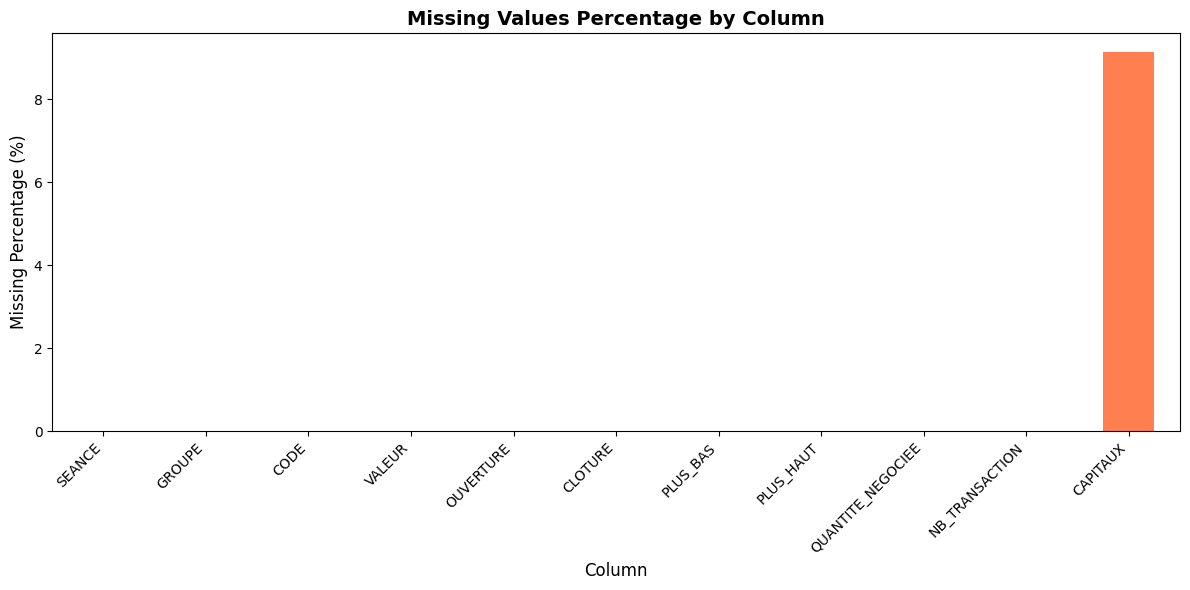

In [15]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_counts = dataset.isnull().sum()
missing_percent = (dataset.isnull().sum() / len(dataset)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})

print(missing_df)
print(f"\nTotal missing values: {dataset.isnull().sum().sum():,}")
print(f"Any missing values: {dataset.isnull().any().any()}")

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df.plot(x='Column', y='Missing_Percent', kind='bar', 
                color='coral', legend=False, figsize=(12, 6))
plt.title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
plt.xlabel('Column', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
# Select rows where CAPITAUX is null
missing_capitaux = dataset[dataset['CAPITAUX'].isnull()]

# View the range of dates in SEANCE for those rows
if not missing_capitaux.empty:
    min_date = missing_capitaux['SEANCE'].min()
    max_date = missing_capitaux['SEANCE'].max()
    print(f"Date range for missing CAPITAUX: {min_date} to {max_date}")
    print(f"Number of missing rows: {len(missing_capitaux)}")
else:
    print("No missing values in CAPITAUX column")

Date range for missing CAPITAUX: 2018-01-02 00:00:00 to 2019-12-31 00:00:00
Number of missing rows: 110476


In [17]:
# Filter rows where SEANCE is between 2018-01-02 and 2019-12-31 and CAPITAUX is not null
filtered_rows = dataset[
    (dataset['SEANCE'] >= '2018-01-02') & 
    (dataset['SEANCE'] <= '2019-12-31') & 
    (dataset['CAPITAUX'].notnull())
]

print(f"Number of rows with non-null CAPITAUX in 2018-2019: {len(filtered_rows)}")
if not filtered_rows.empty:
    display(filtered_rows.head())
else:
    print("No rows found with non-null CAPITAUX in that date range.")

Number of rows with non-null CAPITAUX in 2018-2019: 41712


,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
259752,2018-01-02,11,725001,ADWYA,5.25,5.39,5.25,5.39,2926,7,15635.50
259753,2018-01-02,11,340005,AMEN BANK,24.38,24.00,24.00,24.38,1519,12,36918.00
259754,2018-01-02,11,730001,ARTES,6.27,6.10,6.09,6.27,35875,67,219020.05
259756,2018-01-02,11,360035,ATB,4.15,4.18,4.15,4.18,3705,7,15465.90
259757,2018-01-02,11,774001,ATELIER MEUBLE INT,2.42,2.49,2.42,2.49,195,3,472.25


In [18]:
# Check if all missing CAPITAUX rows have NB_TRANSACTION == 0
missing_capitaux = dataset[dataset['CAPITAUX'].isnull()]

# Count rows where NB_TRANSACTION is not 0 among missing CAPITAUX
non_zero_nb_trans = missing_capitaux[missing_capitaux['NB_TRANSACTION'] != 0]

if len(non_zero_nb_trans) == 0:
    print("All rows with missing CAPITAUX have NB_TRANSACTION == 0")
else:
    print(f"Number of rows with missing CAPITAUX but NB_TRANSACTION != 0: {len(non_zero_nb_trans)}")
    display(non_zero_nb_trans.head())

All rows with missing CAPITAUX have NB_TRANSACTION == 0


In [19]:
# Fill missing CAPITAUX values with 0 where NB_TRANSACTION == 0
dataset.loc[dataset['CAPITAUX'].isnull() & (dataset['NB_TRANSACTION'] == 0), 'CAPITAUX'] = 0

print(f"Missing CAPITAUX values after filling: {dataset['CAPITAUX'].isnull().sum()}")

Missing CAPITAUX values after filling: 6


MISSING VALUES ANALYSIS
               Column  Missing_Count  Missing_Percent
0              SEANCE              6         0.000496
1              GROUPE              6         0.000496
2                CODE              2         0.000165
3              VALEUR              2         0.000165
4           OUVERTURE              6         0.000496
5             CLOTURE              6         0.000496
6            PLUS_BAS              6         0.000496
7           PLUS_HAUT              6         0.000496
8   QUANTITE_NEGOCIEE              6         0.000496
9      NB_TRANSACTION              6         0.000496
10           CAPITAUX              6         0.000496

Total missing values: 58
Any missing values: True


<Figure size 1200x600 with 0 Axes>

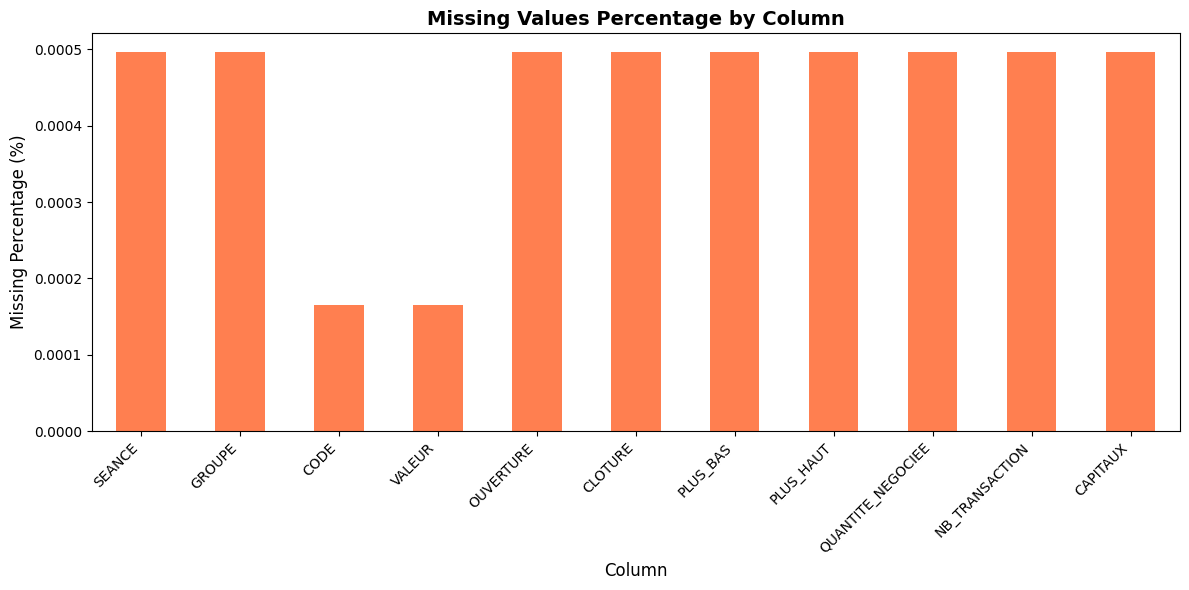

In [20]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_counts = dataset.isnull().sum()
missing_percent = (dataset.isnull().sum() / len(dataset)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_percent.values
})

print(missing_df)
print(f"\nTotal missing values: {dataset.isnull().sum().sum():,}")
print(f"Any missing values: {dataset.isnull().any().any()}")

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df.plot(x='Column', y='Missing_Percent', kind='bar', 
                color='coral', legend=False, figsize=(12, 6))
plt.title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
plt.xlabel('Column', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Find rows with any missing values
rows_with_missing = dataset[dataset.isnull().any(axis=1)]

print(f"\nTotal rows with at least one missing value: {len(rows_with_missing)}")
print(f"Percentage of dataset: {(len(rows_with_missing)/len(dataset))*100:.2f}%")

display(rows_with_missing)


Total rows with at least one missing value: 6
Percentage of dataset: 0.00%


,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
602346,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN
602347,NaT,<NA>,CODE,VALEUR,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN
602348,NaT,<NA>,------------,--------------------,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN
652346,NaT,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN
652347,NaT,<NA>,CODE,VALEUR,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN
652348,NaT,<NA>,------------,--------------------,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN


In [22]:
# Drop all rows with missing values
print("DROPPING ROWS WITH MISSING VALUES")

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")

# Drop rows with any missing values
dataset = dataset.dropna()

# New shape after dropping
new_shape = dataset.shape
rows_dropped = original_shape[0] - new_shape[0]

print(f"\nDataset shape after dropping missing values: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows dropped: {rows_dropped}")
print(f"Percentage of data removed: {(rows_dropped/original_shape[0])*100:.2f}%")

# Sanity check - verify no missing values remain
print("SANITY CHECK - MISSING VALUES VERIFICATION")

missing_after = dataset.isnull().sum()
total_missing = missing_after.sum()

print(f"\nTotal missing values after cleanup: {total_missing}")
print(f"Any missing values remaining: {dataset.isnull().any().any()}")

if total_missing == 0:
    print("\n SUCCESS: No missing values remain in the dataset!")
else:
    print(f"\n WARNING: {total_missing} missing values still present!")
    print("\nMissing values by column:")
    print(missing_after[missing_after > 0])

print("FINAL DATASET SUMMARY")
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Columns: {dataset.shape[1]}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DROPPING ROWS WITH MISSING VALUES

Original dataset shape: (1209103, 11)
Original number of rows: 1,209,103

Dataset shape after dropping missing values: (1209097, 11)
New number of rows: 1,209,097
Rows dropped: 6
Percentage of data removed: 0.00%
SANITY CHECK - MISSING VALUES VERIFICATION

Total missing values after cleanup: 0
Any missing values remaining: False

 SUCCESS: No missing values remain in the dataset!
FINAL DATASET SUMMARY
Shape: (1209097, 11)
Rows: 1,209,097
Columns: 11
Memory usage: 228.64 MB


TRADING DAYS PER CODE (TICKER) ANALYSIS

Total unique CODEs: 1,584

Trading Days Statistics:
  Mean: 763.32 days
  Median: 752 days
  Min: 2 days
  Max: 1257 days
  Std: 422.80 days

TOP 10 MOST TRACKED CODES


,CODE,Trading_Days
760,TN0001000108,1257
761,TN0001000116,1257
762,TN0001000124,1257
1277,TN0007630015,1257
1279,TN0007650013,1257
1281,TN0007670011,1257
1282,TN0007680010,1257
1283,TN0007680044,1257
1284,TN0007680051,1257
1286,TN0007690019,1257



BOTTOM 10 LEAST TRACKED CODES


,CODE,Trading_Days
1409,TNA3Z7AYXXX2,9
1314,TN0008000564,8
1519,TNQEVW1AZTU8,8
1460,TNI7FVNGCJ77,8
549,720007,6
550,720008,6
1285,TN0007680077,5
718,783001,3
1121,TN0006640023,2
1120,TN0006640015,2



DISTRIBUTION OF TRADING DAYS
Days_Range
0-50         65
51-100       22
101-250     120
251-500     251
501-750     286
751-1000    239
1000+       601
Name: count, dtype: int64


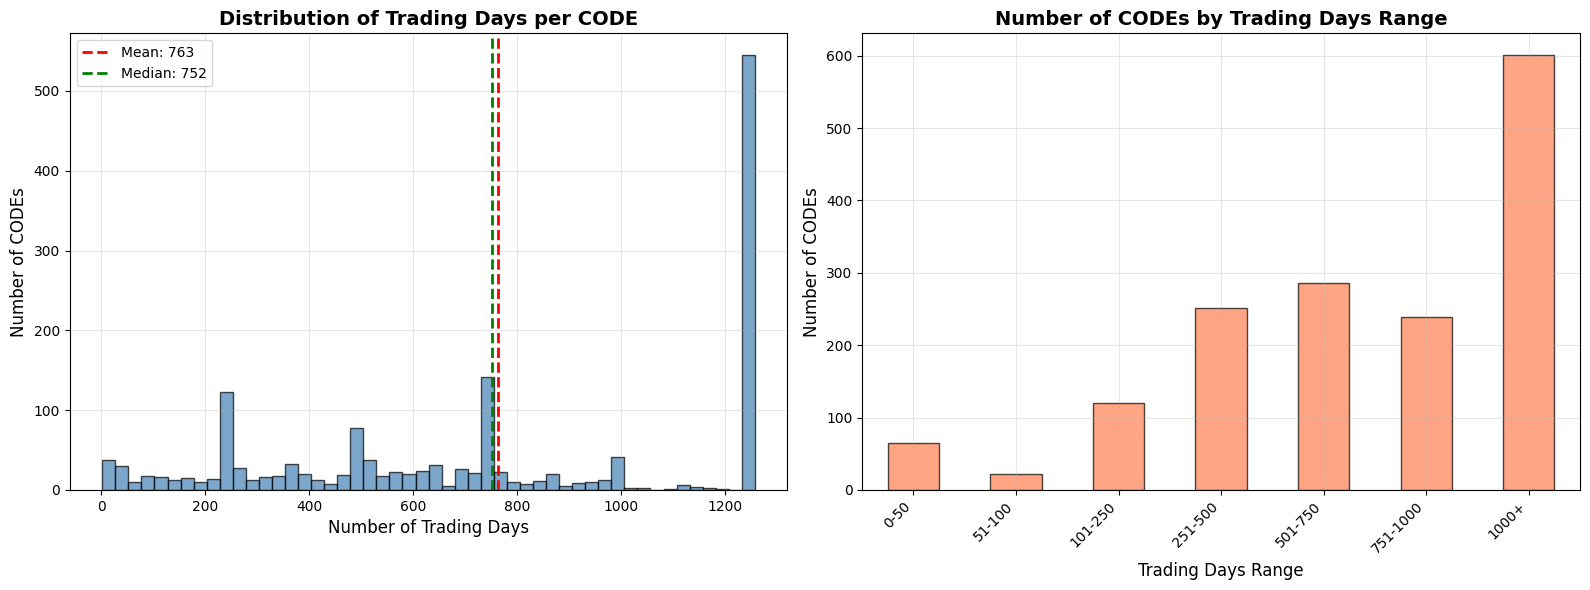

In [23]:
# Analyze how many trading days each CODE has been tracked
print("=" * 80)
print("TRADING DAYS PER CODE (TICKER) ANALYSIS")
print("=" * 80)

# Count unique SEANCE dates for each CODE
days_per_code = dataset.groupby('CODE')['SEANCE'].nunique().reset_index()
days_per_code.columns = ['CODE', 'Trading_Days']
days_per_code = days_per_code.sort_values('Trading_Days', ascending=False)

print(f"\nTotal unique CODEs: {len(days_per_code):,}")
print(f"\nTrading Days Statistics:")
print(f"  Mean: {days_per_code['Trading_Days'].mean():.2f} days")
print(f"  Median: {days_per_code['Trading_Days'].median():.0f} days")
print(f"  Min: {days_per_code['Trading_Days'].min()} days")
print(f"  Max: {days_per_code['Trading_Days'].max()} days")
print(f"  Std: {days_per_code['Trading_Days'].std():.2f} days")

print("\n" + "=" * 80)
print("TOP 10 MOST TRACKED CODES")
print("=" * 80)
display(days_per_code.head(10))

print("\n" + "=" * 80)
print("BOTTOM 10 LEAST TRACKED CODES")
print("=" * 80)
display(days_per_code.tail(10))

print("\n" + "=" * 80)
print("DISTRIBUTION OF TRADING DAYS")
print("=" * 80)

# Create bins for better understanding
bins = [0, 50, 100, 250, 500, 750, 1000, days_per_code['Trading_Days'].max() + 1]
labels = ['0-50', '51-100', '101-250', '251-500', '501-750', '751-1000', '1000+']
days_per_code['Days_Range'] = pd.cut(days_per_code['Trading_Days'], bins=bins, labels=labels, right=False)

distribution = days_per_code['Days_Range'].value_counts().sort_index()
print(distribution)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(days_per_code['Trading_Days'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Trading Days per CODE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Trading Days', fontsize=12)
axes[0].set_ylabel('Number of CODEs', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].axvline(days_per_code['Trading_Days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {days_per_code["Trading_Days"].mean():.0f}')
axes[0].axvline(days_per_code['Trading_Days'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {days_per_code["Trading_Days"].median():.0f}')
axes[0].legend()

# Bar chart of ranges
distribution.plot(kind='bar', ax=axes[1], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Number of CODEs by Trading Days Range', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Trading Days Range', fontsize=12)
axes[1].set_ylabel('Number of CODEs', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Unique values per column
print("=" * 60)
print("UNIQUE VALUES PER COLUMN")
print("=" * 60)

unique_df = pd.DataFrame({
    'Column': dataset.columns,
    'Unique_Count': [dataset[col].nunique() for col in dataset.columns],
    'Sample_Values': [dataset[col].unique()[:] if dataset[col].nunique() <= 10 
                      else f"{dataset[col].unique()[:3]}... (showing 3 of {dataset[col].nunique()})" 
                      for col in dataset.columns]
})

for idx, row in unique_df.iterrows():
    if(row['Column'] in ['SEANCE', 'GROUPE', 'CODE', 'VALEUR']):
        print(f"\n{row['Column']}:")
        print(f"  Unique values: {row['Unique_Count']:,}")
        print(f"  Sample: {row['Sample_Values']}")

UNIQUE VALUES PER COLUMN

SEANCE:
  Unique values: 2,508
  Sample: <DatetimeArray>
['2016-01-04 00:00:00', '2016-01-05 00:00:00', '2016-01-06 00:00:00']
Length: 3, dtype: datetime64[ns]... (showing 3 of 2508)

GROUPE:
  Unique values: 10
  Sample: <IntegerArray>
[11, 12, 13, 21, 32, 51, 52, 71, 99, 33]
Length: 10, dtype: Int64

CODE:
  Unique values: 1,584
  Sample: [100010 110025 120040]... (showing 3 of 1584)

VALEUR:
  Unique values: 1,444
  Sample: ['MONOPRIX' 'SFBT' 'TUNISAIR']... (showing 3 of 1444)


In [25]:
# Check for duplicate rows
print("=" * 60)
print("DUPLICATE ROWS ANALYSIS")
print("=" * 60)

# Check for exact duplicates (all columns)
total_duplicates = dataset.duplicated().sum()
print(f"\nTotal duplicate rows (all columns): {total_duplicates:,}")
print(f"Percentage of duplicates: {(total_duplicates/len(dataset))*100:.2f}%")

# Check for duplicates based on key columns (SEANCE, CODE)
key_duplicates = dataset.duplicated(subset=['SEANCE', 'CODE']).sum()
print(f"\nDuplicate rows based on SEANCE + CODE: {key_duplicates:,}")
print(f"Percentage: {(key_duplicates/len(dataset))*100:.2f}%")

# View some duplicate rows if they exist
if total_duplicates > 0:
    print("\nSample of duplicate rows:")
    duplicates_df = dataset[dataset.duplicated(keep=False)].sort_values(['SEANCE', 'CODE'])
    display(duplicates_df.head(10))
    
if key_duplicates > 0:
    print("\nSample of key duplicates (SEANCE + CODE):")
    key_dups = dataset[dataset.duplicated(subset=['SEANCE', 'CODE'], keep=False)].sort_values(['SEANCE', 'CODE'])
    display(key_dups.head(10))

DUPLICATE ROWS ANALYSIS

Total duplicate rows (all columns): 0
Percentage of duplicates: 0.00%

Duplicate rows based on SEANCE + CODE: 0
Percentage: 0.00%


CONSISTENCY CHECK ACROSS YEARS

Unique Values Per Year:


,Year,Total_Rows,Unique_Trading_Days,Unique_Groups,Unique_Codes,Unique_Values
0,2016,126065,251,9,542,550
1,2017,133687,252,10,582,588
2,2018,74594,249,8,308,309
3,2019,77588,249,8,323,324
4,2020,140415,250,9,613,625
5,2021,137366,248,7,604,793
6,2022,83939,257,6,331,331
7,2023,147209,252,7,659,659
8,2024,145381,251,7,645,645
9,2025,142853,249,6,612,612


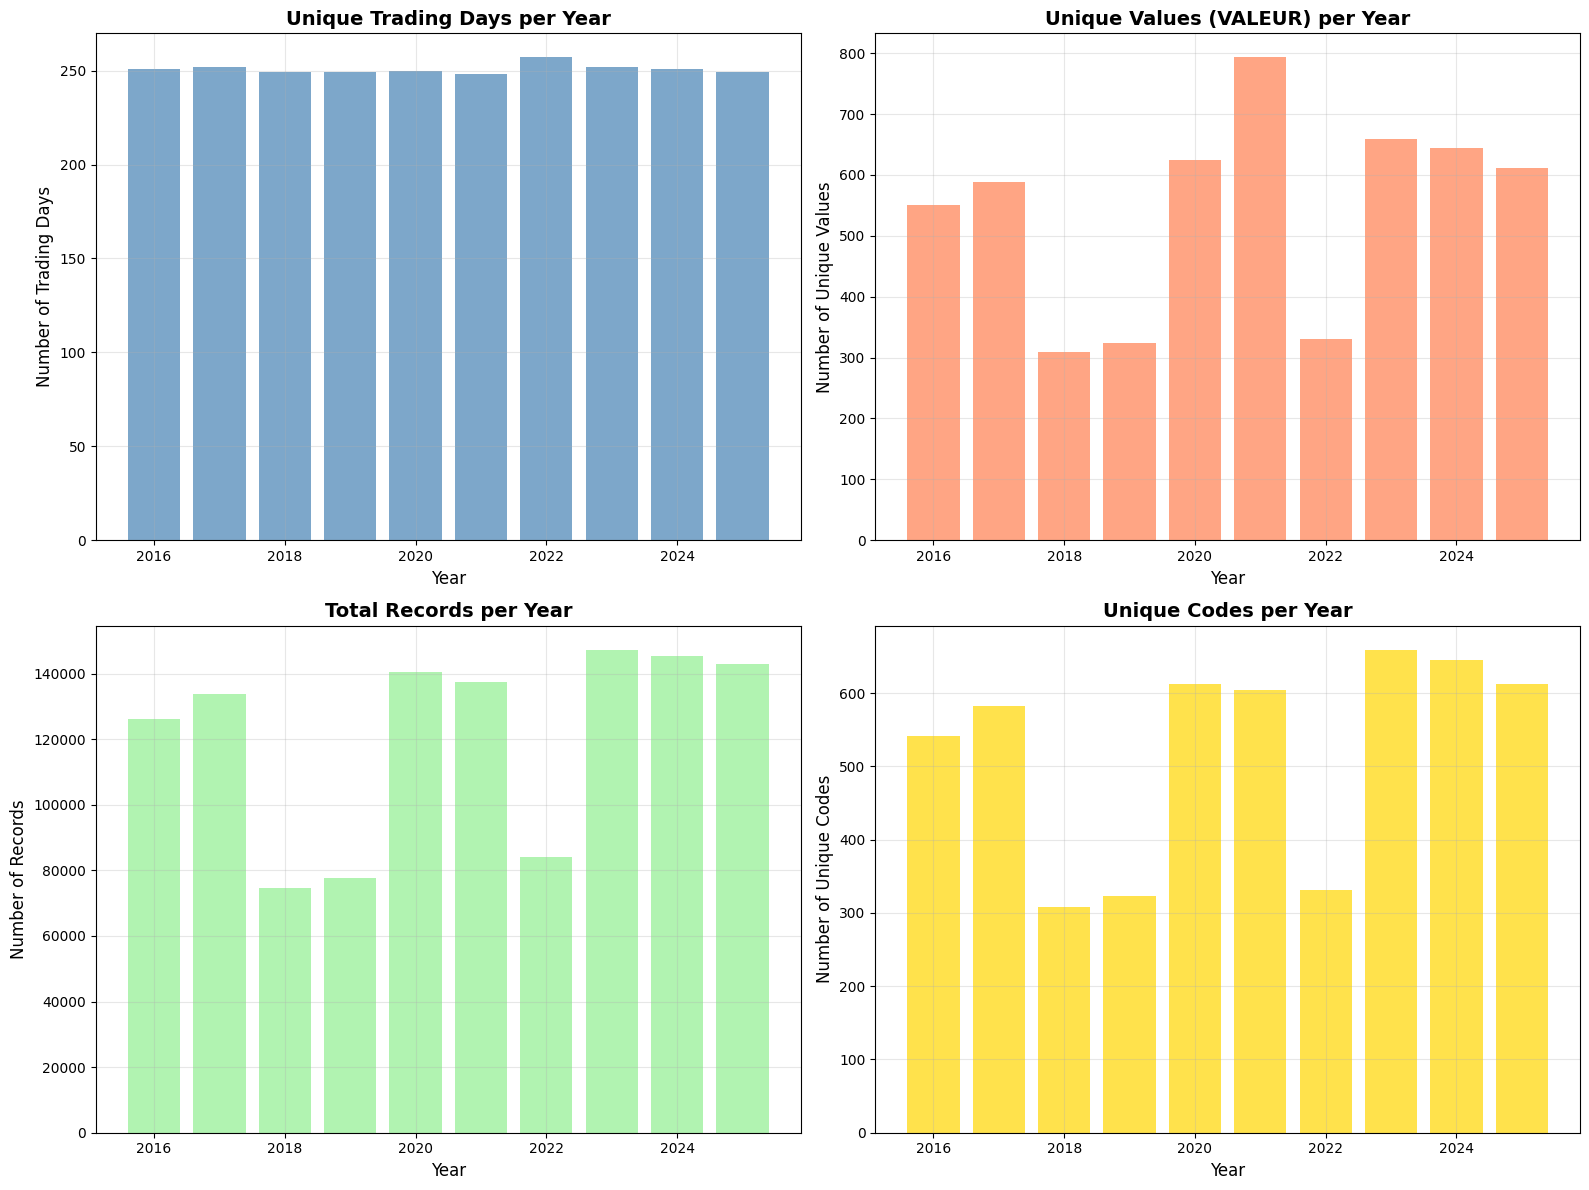

In [26]:
# Check consistency over years
print("=" * 80)
print("CONSISTENCY CHECK ACROSS YEARS")
print("=" * 80)

# Extract year from SEANCE column
dataset.loc[:, 'YEAR'] = dataset['SEANCE'].dt.year

# Group by year and count unique values for key columns
columns_to_check = ['SEANCE', 'GROUPE', 'CODE', 'VALEUR']

consistency_report = []
for year in sorted(dataset['YEAR'].unique()):
    year_data = dataset[dataset['YEAR'] == year]
    
    year_stats = {
        'Year': year,
        'Total_Rows': len(year_data),
        'Unique_Trading_Days': year_data['SEANCE'].nunique(),
        'Unique_Groups': year_data['GROUPE'].nunique(),
        'Unique_Codes': year_data['CODE'].nunique(),
        'Unique_Values': year_data['VALEUR'].nunique()
    }
    consistency_report.append(year_stats)

# Create DataFrame from the report
consistency_df = pd.DataFrame(consistency_report)

print("\nUnique Values Per Year:")
print("=" * 80)
display(consistency_df)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Trading Days per Year
axes[0, 0].bar(consistency_df['Year'], consistency_df['Unique_Trading_Days'], color='steelblue', alpha=0.7)
axes[0, 0].set_title('Unique Trading Days per Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Number of Trading Days', fontsize=12)
axes[0, 0].grid(alpha=0.3)

# 2. Unique Values per Year
axes[0, 1].bar(consistency_df['Year'], consistency_df['Unique_Values'], color='coral', alpha=0.7)
axes[0, 1].set_title('Unique Values (VALEUR) per Year', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year', fontsize=12)
axes[0, 1].set_ylabel('Number of Unique Values', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# 3. Total Rows per Year
axes[1, 0].bar(consistency_df['Year'], consistency_df['Total_Rows'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Total Records per Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Number of Records', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# 4. Unique Codes per Year
axes[1, 1].bar(consistency_df['Year'], consistency_df['Unique_Codes'], color='gold', alpha=0.7)
axes[1, 1].set_title('Unique Codes per Year', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Number of Unique Codes', fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
# Remove the YEAR column if not needed
dataset = dataset.drop('YEAR', axis=1)

In [27]:
# Analyze CODE to VALEUR mapping
print("=" * 80)
print("CODE to VALEUR MAPPING ANALYSIS")
print("=" * 80)

# For each CODE, count unique VALEUR values
code_to_valeur = dataset.groupby('CODE')['VALEUR'].nunique().reset_index()
code_to_valeur.columns = ['CODE', 'Unique_VALEUR_Count']
code_to_valeur = code_to_valeur.sort_values('Unique_VALEUR_Count', ascending=False)

print("\n1. For each CODE, how many unique VALEUR values:")
print(f"\nTotal unique CODEs: {len(code_to_valeur)}")
print(f"\nDistribution of VALEUR counts per CODE:")
print(code_to_valeur['Unique_VALEUR_Count'].value_counts().sort_index())

# For each VALEUR, count unique CODE values
print('\n' + "=" * 80)
print("VALEUR to CODE MAPPING ANALYSIS")
print( "=" * 80)

valeur_to_code = dataset.groupby('VALEUR')['CODE'].nunique().reset_index()
valeur_to_code.columns = ['VALEUR', 'Unique_CODE_Count']
valeur_to_code = valeur_to_code.sort_values('Unique_CODE_Count', ascending=False)

print("\n2. For each VALEUR, how many unique CODE values:")
print(f"\nTotal unique VALEURs: {len(valeur_to_code)}")
print(f"\nDistribution of CODE counts per VALEUR:")
print(valeur_to_code['Unique_CODE_Count'].value_counts().sort_index())

CODE to VALEUR MAPPING ANALYSIS

1. For each CODE, how many unique VALEUR values:

Total unique CODEs: 1584

Distribution of VALEUR counts per CODE:
Unique_VALEUR_Count
1    1243
2     262
3      79
Name: count, dtype: int64

VALEUR to CODE MAPPING ANALYSIS

2. For each VALEUR, how many unique CODE values:

Total unique VALEURs: 1444

Distribution of CODE counts per VALEUR:
Unique_CODE_Count
1    884
2    560
Name: count, dtype: int64


In [28]:
tickers_to_keep = ['ADWYA',                        'AETECH',
           'AIR LIQUIDE TUNISIE',                     'AMEN BANK',
                           'AMS',            'ARAB TUNISIAN BANK',
           'ARAB TUNISIAN LEASE',                         'ARTES',
                         'ASSAD',          'ASSURANCES MAGHREBIA',
                        'ASTREE',                 'ATTIJARI BANK',
              'ATTIJARI LEASING',             'BANQUE DE TUNISIE',
     'BANQUE NATIONALE AGRICOLE',                    'BEST LEASE',
                  'BH ASSURANCE',                       'BH BANK',
                    'BH LEASING',                          'BIAT',
                'BNA ASSURANCES',                     'BTE (ADP)',
               'CARTHAGE CEMENT',                       'CELLCOM',
                      'CEREALIS',                           'CIL',
            'CIMENTS DE BIZERTE',                     'CITY CARS',
                'DELICE HOLDING',                        'ELBENE',
                   'ELECTROSTAR',            'ENNAKL AUTOMOBILES',
                      'ESSOUKNA',                   'EURO-CYCLES',
                    'GIF FILTER',                'HANNIBAL LEASE',
                      'HEXABYTE',                           'ICF',
                       "LAND'OR",               'MAGASIN GENERAL',
                 'MAGHREBIA VIE',            'MEUBLES INTERIEURS',
                           'MIP',                      'MONOPRIX',
                          'MPBS',                 'NEW BODY LINE',
                  'OFFICE PLAST',                      'ONE TECH',
 'PLACEMENTS DE TUNISIE - SICAF',         'POULINA GROUP HOLDING',
                           'SAH',                       'SANIMED',
                      'SERVICOM',                          'SFBT',
                         'SIAME',                        'SIMPAR',
                        'SIPHAT',                          'SITS',
                 'SMART TUNISIE',      'SOCIETE CHIMIQUE ALKIMIA',
                       'SOMOCER',                         'SOPAT',
                      'SOTEMAIL',                       'SOTETEL',
                    'SOTIPAPIER',                      'SOTRAPIL',
                       'SOTUMAG',                       'SOTUVER',
                 'SPDIT - SICAF',                           'STA',
                          'STAR',                      'STB BANK',
                          'STEQ',                          'STIP',
               'SYPHAX AIRLINES',                       'TAWASOL',
                'TELNET HOLDING',                           'TPR',
                      'TUNINDEX',             'TUNINVEST - SICAR',
                      'TUNIS RE',                      'TUNISAIR',
           'TUNISIAN BOND INDEX',   'TUNISIE LEASING & FACTORING',
               'TUNISIE VALEURS',                          'UADH',
                          'UBCI',                           'UIB',
                        'UNIMED',                'WIFAK INT BANK']

In [29]:
tickers_to_keep_series = pd.Series(tickers_to_keep)
tickers_to_keep_series.nunique()

90

In [30]:
# Convert CODE and VALEUR columns to string type
dataset['CODE'] = dataset['CODE'].astype('string')
dataset['VALEUR'] = dataset['VALEUR'].astype('string')

# Strip whitespace from CODE and VALEUR
dataset['CODE'] = dataset['CODE'].str.strip()
dataset['VALEUR'] = dataset['VALEUR'].str.strip()

print("Column types after conversion:")
print(f"CODE: {dataset['CODE'].dtype}")
print(f"VALEUR: {dataset['VALEUR'].dtype}")

# Verify the conversion
dataset.info()

# Check unique values after stripping
print(f"\nUnique VALEUR values after stripping: {dataset['VALEUR'].nunique()}")
print(f"Unique CODE values after stripping: {dataset['CODE'].nunique()}")

Column types after conversion:
CODE: string
VALEUR: string
<class 'pandas.core.frame.DataFrame'>
Index: 1209097 entries, 0 to 1209102
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   SEANCE             1209097 non-null  datetime64[ns]
 1   GROUPE             1209097 non-null  Int64         
 2   CODE               1209097 non-null  string        
 3   VALEUR             1209097 non-null  string        
 4   OUVERTURE          1209097 non-null  float64       
 5   CLOTURE            1209097 non-null  float64       
 6   PLUS_BAS           1209097 non-null  float64       
 7   PLUS_HAUT          1209097 non-null  float64       
 8   QUANTITE_NEGOCIEE  1209097 non-null  Int64         
 9   NB_TRANSACTION     1209097 non-null  Int64         
 10  CAPITAUX           1209097 non-null  float64       
dtypes: Int64(3), datetime64[ns](1), float64(5), string(2)
memory usage: 114.2 MB

Unique VA

In [31]:
# Validate tickers_to_keep against dataset
print("=" * 80)
print("TICKER VALIDATION ANALYSIS")
print("=" * 80)

# Get all unique VALEUR values from dataset
dataset_valeurs = set(dataset['VALEUR'].unique())

# Convert tickers_to_keep to set for comparison
tickers_set = set(tickers_to_keep)

print(f"\nTotal tickers to keep: {len(tickers_to_keep)}")
print(f"Unique tickers in dataset: {len(dataset_valeurs)}")

# Find tickers that exist in dataset
existing_tickers = tickers_set.intersection(dataset_valeurs)
print(f"\nTickers that EXIST in dataset: {len(existing_tickers)}")

# Find tickers that DON'T exist in dataset
missing_tickers = tickers_set.difference(dataset_valeurs)
print(f"Tickers that are MISSING from dataset: {len(missing_tickers)}")

if missing_tickers:
    print("\n" + "=" * 80)
    print("WARNING: MISSING TICKERS - NOT FOUND IN DATASET")
    print("=" * 80)
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\nSUCCESS: All tickers exist in the dataset!")

# Statistics for existing tickers
if existing_tickers:
    print("\n" + "=" * 80)
    print("STATISTICS FOR EXISTING TICKERS")
    print("=" * 80)
    
    existing_data = dataset[dataset['VALEUR'].isin(existing_tickers)]
    print(f"\nTotal rows for existing tickers: {len(existing_data):,}")
    print(f"Percentage of dataset: {(len(existing_data)/len(dataset))*100:.2f}%")
    
    # Trading days per existing ticker
    ticker_stats = existing_data.groupby('VALEUR')['SEANCE'].nunique().describe()
    print(f"\nTrading days statistics for existing tickers:")
    print(ticker_stats)

TICKER VALIDATION ANALYSIS



Total tickers to keep: 90
Unique tickers in dataset: 1246

Tickers that EXIST in dataset: 65
Tickers that are MISSING from dataset: 25

  - AIR LIQUIDE TUNISIE
  - ARAB TUNISIAN BANK
  - ARAB TUNISIAN LEASE
  - ASSURANCES MAGHREBIA
  - BANQUE DE TUNISIE
  - BANQUE NATIONALE AGRICOLE
  - ELBENE
  - GIF FILTER
  - LAND'OR
  - MAGHREBIA VIE
  - MEUBLES INTERIEURS
  - MIP
  - OFFICE PLAST
  - ONE TECH
  - PLACEMENTS DE TUNISIE - SICAF
  - POULINA GROUP HOLDING
  - SOCIETE CHIMIQUE ALKIMIA
  - STB BANK
  - SYPHAX AIRLINES
  - TAWASOL
  - TUNINDEX
  - TUNINVEST - SICAR
  - TUNISIAN BOND INDEX
  - TUNISIE LEASING & FACTORING
  - WIFAK INT BANK

STATISTICS FOR EXISTING TICKERS

Total rows for existing tickers: 146,303
Percentage of dataset: 12.10%

Trading days statistics for existing tickers:
count      65.000000
mean     2250.815385
std       528.171282
min       459.000000
25%      2426.000000
50%      2508.000000
75%      2508.000000
max      2508.000000
Name: SEANCE, dtype: float64


In [32]:
# Convert CODE and VALEUR columns to string type
dataset['CODE'] = dataset['CODE'].astype('string')
dataset['VALEUR'] = dataset['VALEUR'].astype('string')

print("Column types after conversion:")
print(f"CODE: {dataset['CODE'].dtype}")
print(f"VALEUR: {dataset['VALEUR'].dtype}")

# Verify the conversion
dataset.info()

Column types after conversion:
CODE: string
VALEUR: string
<class 'pandas.core.frame.DataFrame'>
Index: 1209097 entries, 0 to 1209102
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   SEANCE             1209097 non-null  datetime64[ns]
 1   GROUPE             1209097 non-null  Int64         
 2   CODE               1209097 non-null  string        
 3   VALEUR             1209097 non-null  string        
 4   OUVERTURE          1209097 non-null  float64       
 5   CLOTURE            1209097 non-null  float64       
 6   PLUS_BAS           1209097 non-null  float64       
 7   PLUS_HAUT          1209097 non-null  float64       
 8   QUANTITE_NEGOCIEE  1209097 non-null  Int64         
 9   NB_TRANSACTION     1209097 non-null  Int64         
 10  CAPITAUX           1209097 non-null  float64       
dtypes: Int64(3), datetime64[ns](1), float64(5), string(2)
memory usage: 114.2 MB


In [33]:
# Analyze missing tickers to find potential name variations
print("=" * 80)
print("MISSING TICKERS NAME MATCHING ANALYSIS")
print("=" * 80)

# Get first words from missing tickers
missing_first_words = {ticker: ticker.split()[0] for ticker in missing_tickers}

# Get first words from dataset tickers
dataset_first_words = {ticker: ticker.split()[0] for ticker in dataset_valeurs}

# Find matches: missing ticker first word matches dataset ticker first word
print("\n1. POTENTIAL MATCHES (First word comparison):")
print("=" * 80)

matched_missing = set()
matched_dataset = set()

for missing_ticker in missing_tickers:
    missing_first = missing_ticker.split()[0]
    
    for dataset_ticker in dataset_valeurs:
        dataset_first = dataset_ticker.split()[0]
        
        if missing_first == dataset_first:
            print(f"\nMissing: {missing_ticker}")
            print(f"Dataset: {dataset_ticker}")
            matched_missing.add(missing_ticker)
            matched_dataset.add(dataset_ticker)

# Find unmatched missing tickers
unmatched_missing = missing_tickers - matched_missing

print("\n" + "=" * 80)
print("2. UNMATCHED MISSING TICKERS (No first-word match found):")
print("=" * 80)

if unmatched_missing:
    for ticker in sorted(unmatched_missing):
        print(f"  - {ticker}")
else:
    print("All missing tickers have potential matches!")

print("\n" + "=" * 80)
print("SUMMARY:")
print("=" * 80)
print(f"Total missing tickers: {len(missing_tickers)}")
print(f"Matched (potential name variations): {len(matched_missing)}")
print(f"Unmatched (likely not in dataset): {len(unmatched_missing)}")

MISSING TICKERS NAME MATCHING ANALYSIS

1. POTENTIAL MATCHES (First word comparison):

Missing: TUNISIE LEASING & FACTORING
Dataset: TUNISIE VALEURS

Missing: TUNISIE LEASING & FACTORING
Dataset: TUNISIE LEASING F

Missing: TUNISIE LEASING & FACTORING
Dataset: TUNISIE LEASING

Missing: STB BANK
Dataset: STB SA1124 10,5%P5

Missing: STB BANK
Dataset: STB SA1124T+2.3%P5

Missing: STB BANK
Dataset: STB SA0425 10.5%P5

Missing: STB BANK
Dataset: STB

Missing: STB BANK
Dataset: STB SB0119 6.1P7

Missing: STB BANK
Dataset: STB NS J 01072015

Missing: STB BANK
Dataset: STB SC1126 11%P7-2

Missing: STB BANK
Dataset: STB SA1124 10.5%P5

Missing: STB BANK
Dataset: STB SA0425 10,5%P5

Missing: STB BANK
Dataset: STB Sb0122T+1.3P10

Missing: STB BANK
Dataset: STB SC0427 11%P7-2

Missing: STB BANK
Dataset: STB SB0122T+1.3P10

Missing: POULINA GROUP HOLDING
Dataset: POULINA GP HOLDING

Missing: ONE TECH
Dataset: ONE TECH HOLDING

Missing: WIFAK INT BANK
Dataset: WIFAK DA1/2 121015

Missing: ASSURANCE

In [34]:
# Create mapping dictionary for ticker name corrections
ticker_mapping = {
    'TUNISIE LEASING F': 'TUNISIE LEASING & FACTORING',
    'TUNISIE LEASING': 'TUNISIE LEASING & FACTORING',
    'ELBENE INDUSTRIE': 'ELBENE',
    'POULINA GP HOLDING': 'POULINA GROUP HOLDING',
    'ONE TECH HOLDING': 'ONE TECH',
    'AIR LIQUIDE TSIE': 'AIR LIQUIDE TUNISIE',
    'AIR LIQUDE TSIE': 'AIR LIQUIDE TUNISIE',
    'STB': 'STB BANK',
    'TAWASOL GP HOLDING': 'TAWASOL'
}

print("RENAMING VALEUR VALUES TO MATCH TARGET TICKERS")

# Show current counts before replacement
print("\nBefore replacement:")
for old_name, new_name in ticker_mapping.items():
    count = (dataset['VALEUR'] == old_name).sum()
    if count > 0:
        print(f"  {old_name}: {count:,} rows")

# Apply the mapping
dataset['VALEUR'] = dataset['VALEUR'].replace(ticker_mapping)

# Show counts after replacement
print("\nAfter replacement:")
for new_name in set(ticker_mapping.values()):
    count = (dataset['VALEUR'] == new_name).sum()
    print(f"  {new_name}: {count:,} rows")

print("VALIDATION")

# Refresh dataset_valeurs after renaming
dataset_valeurs = set(dataset['VALEUR'].unique())

# Re-validate tickers
tickers_set = set(tickers_to_keep)
existing_tickers = tickers_set.intersection(dataset_valeurs)
missing_tickers = tickers_set.difference(dataset_valeurs)

print(f"\nTotal tickers to keep: {len(tickers_to_keep)}")
print(f"Tickers that NOW EXIST in dataset: {len(existing_tickers)}")
print(f"Tickers still MISSING from dataset: {len(missing_tickers)}")

if missing_tickers:
    print("\nRemaining missing tickers:")
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")
else:
    print("\n SUCCESS: All tickers now exist in the dataset!")

RENAMING VALEUR VALUES TO MATCH TARGET TICKERS

Before replacement:
  TUNISIE LEASING F: 1,856 rows
  TUNISIE LEASING: 652 rows
  ELBENE INDUSTRIE: 1,127 rows
  POULINA GP HOLDING: 2,508 rows
  ONE TECH HOLDING: 2,508 rows
  AIR LIQUIDE TSIE: 1,096 rows
  AIR LIQUDE TSIE: 1,412 rows
  STB: 2,508 rows
  TAWASOL GP HOLDING: 2,508 rows

After replacement:
  TUNISIE LEASING & FACTORING: 2,508 rows
  STB BANK: 2,508 rows
  ELBENE: 1,127 rows
  POULINA GROUP HOLDING: 2,508 rows
  AIR LIQUIDE TUNISIE: 2,508 rows
  TAWASOL: 2,508 rows
  ONE TECH: 2,508 rows
VALIDATION

Total tickers to keep: 90
Tickers that NOW EXIST in dataset: 72
Tickers still MISSING from dataset: 18

Remaining missing tickers:
  - ARAB TUNISIAN BANK
  - ARAB TUNISIAN LEASE
  - ASSURANCES MAGHREBIA
  - BANQUE DE TUNISIE
  - BANQUE NATIONALE AGRICOLE
  - GIF FILTER
  - LAND'OR
  - MAGHREBIA VIE
  - MEUBLES INTERIEURS
  - MIP
  - OFFICE PLAST
  - PLACEMENTS DE TUNISIE - SICAF
  - SOCIETE CHIMIQUE ALKIMIA
  - SYPHAX AIRLINES
 

In [35]:
base_data = dataset.copy()

In [36]:
print("FILTERING DATASET TO KEEP ONLY TARGET TICKERS")

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique VALEUR count: {dataset['VALEUR'].nunique()}")

# Filter dataset to keep only rows where VALEUR is in tickers_to_keep
dataset = dataset[dataset['VALEUR'].isin(tickers_to_keep)]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nNew unique VALEUR count: {dataset['VALEUR'].nunique()}")
print(f"Expected count (tickers_to_keep): {len(tickers_to_keep)}")

# Verify all tickers_to_keep are present
dataset_valeurs = set(dataset['VALEUR'].unique())
tickers_set = set(tickers_to_keep)
existing_tickers = tickers_set.intersection(dataset_valeurs)
missing_tickers = tickers_set.difference(dataset_valeurs)

print(f"\n Tickers present in filtered dataset: {len(existing_tickers)}")
print(f" Tickers still missing: {len(missing_tickers)}")

if missing_tickers:
    print("\nMissing tickers (not found in dataset):")
    for ticker in sorted(missing_tickers):
        print(f"  - {ticker}")

print("\n" + "=" * 80)
print("FILTERED DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

FILTERING DATASET TO KEEP ONLY TARGET TICKERS

Original dataset shape: (1209097, 11)
Original number of rows: 1,209,097
Original unique VALEUR count: 1244

Filtered dataset shape: (162478, 11)
New number of rows: 162,478
Rows removed: 1,046,619
Percentage of data removed: 86.56%

New unique VALEUR count: 72
Expected count (tickers_to_keep): 90

 Tickers present in filtered dataset: 72
 Tickers still missing: 18

Missing tickers (not found in dataset):
  - ARAB TUNISIAN BANK
  - ARAB TUNISIAN LEASE
  - ASSURANCES MAGHREBIA
  - BANQUE DE TUNISIE
  - BANQUE NATIONALE AGRICOLE
  - GIF FILTER
  - LAND'OR
  - MAGHREBIA VIE
  - MEUBLES INTERIEURS
  - MIP
  - OFFICE PLAST
  - PLACEMENTS DE TUNISIE - SICAF
  - SOCIETE CHIMIQUE ALKIMIA
  - SYPHAX AIRLINES
  - TUNINDEX
  - TUNINVEST - SICAR
  - TUNISIAN BOND INDEX
  - WIFAK INT BANK

FILTERED DATASET SUMMARY
Shape: (162478, 11)
Rows: 162,478
Unique tickers: 72
Memory usage: 30.78 MB


In [37]:
# Analyze CODE to VALEUR mapping
print("=" * 80)
print("CODE to VALEUR MAPPING ANALYSIS")
print("=" * 80)

# For each CODE, count unique VALEUR values
code_to_valeur = dataset.groupby('CODE')['VALEUR'].nunique().reset_index()
code_to_valeur.columns = ['CODE', 'Unique_VALEUR_Count']
code_to_valeur = code_to_valeur.sort_values('Unique_VALEUR_Count', ascending=False)

print("\n1. For each CODE, how many unique VALEUR values:")
print(f"\nTotal unique CODEs: {len(code_to_valeur)}")
print(f"\nDistribution of VALEUR counts per CODE:")
print(code_to_valeur['Unique_VALEUR_Count'].value_counts().sort_index())

# For each VALEUR, count unique CODE values
print('\n' + "=" * 80)
print("VALEUR to CODE MAPPING ANALYSIS")
print( "=" * 80)

valeur_to_code = dataset.groupby('VALEUR')['CODE'].nunique().reset_index()
valeur_to_code.columns = ['VALEUR', 'Unique_CODE_Count']
valeur_to_code = valeur_to_code.sort_values('Unique_CODE_Count', ascending=False)

print("\n2. For each VALEUR, how many unique CODE values:")
print(f"\nTotal unique VALEURs: {len(valeur_to_code)}")
print(f"\nDistribution of CODE counts per VALEUR:")
print(valeur_to_code['Unique_CODE_Count'].value_counts().sort_index())

CODE to VALEUR MAPPING ANALYSIS

1. For each CODE, how many unique VALEUR values:

Total unique CODEs: 137

Distribution of VALEUR counts per CODE:
Unique_VALEUR_Count
1    137
Name: count, dtype: int64

VALEUR to CODE MAPPING ANALYSIS

2. For each VALEUR, how many unique CODE values:

Total unique VALEURs: 72

Distribution of CODE counts per VALEUR:
Unique_CODE_Count
1     7
2    65
Name: count, dtype: int64


In [38]:
print("INVESTIGATING CODE CHANGES OVER TIME")

# Get VALEUR values with 2 CODE values
valeur_with_2_codes = valeur_to_code[valeur_to_code['Unique_CODE_Count'] == 2]['VALEUR'].tolist()

print(f"\nNumber of VALEUR with exactly 2 CODEs: {len(valeur_with_2_codes)}")

# Check 1: Are there any rows with same SEANCE + VALEUR but different CODE?
print("CHECK 1: SAME DATE, SAME VALEUR, DIFFERENT CODE")

conflicts_found = False

for valeur in valeur_with_2_codes:
    valeur_data = dataset[dataset['VALEUR'] == valeur]
    
    # Group by SEANCE and count unique CODEs
    conflicts = valeur_data.groupby('SEANCE')['CODE'].nunique()
    conflicts = conflicts[conflicts > 1]
    
    if len(conflicts) > 0:
        conflicts_found = True
        print(f"\n CONFLICT FOUND for {valeur}:")
        print(f"   {len(conflicts)} dates have multiple CODEs")
        
        # Show example
        conflict_date = conflicts.index[0]
        conflict_rows = valeur_data[valeur_data['SEANCE'] == conflict_date][['SEANCE', 'CODE', 'VALEUR', 'CLOTURE']]
        print(f"\n   Example on {conflict_date}:")
        display(conflict_rows)

if not conflicts_found:
    print("\n NO CONFLICTS: No date has the same VALEUR with different CODEs")
    
    # Check 2: Date ranges for each CODE
    print("CHECK 2: DATE RANGES FOR EACH CODE (CODE Changes Over Time)")
    
    code_timeline = []
    
    for valeur in valeur_with_2_codes:
        valeur_data = dataset[dataset['VALEUR'] == valeur]
        
        for code in valeur_data['CODE'].unique():
            code_data = valeur_data[valeur_data['CODE'] == code]
            
            code_timeline.append({
                'VALEUR': valeur,
                'CODE': code,
                'First_Date': code_data['SEANCE'].min(),
                'Last_Date': code_data['SEANCE'].max(),
                'Total_Days': code_data['SEANCE'].nunique(),
                'Total_Rows': len(code_data)
            })
    
    timeline_df = pd.DataFrame(code_timeline)
    timeline_df = timeline_df.sort_values(['VALEUR', 'First_Date'])
    
    print(f"\nShowing timeline for all {len(valeur_with_2_codes)} VALEUR with 2 CODEs:\n")
    display(timeline_df)
    
    # Check for overlaps
    print("CHECK 3: DETECTING OVERLAPS")
    
    overlaps_found = False
    
    for valeur in valeur_with_2_codes:
        valeur_timeline = timeline_df[timeline_df['VALEUR'] == valeur].sort_values('First_Date')
        
        if len(valeur_timeline) == 2:
            first_record = valeur_timeline.iloc[0]
            second_record = valeur_timeline.iloc[1]
            
            # Check if date ranges overlap
            if first_record['Last_Date'] >= second_record['First_Date']:
                overlaps_found = True
                print(f"\n OVERLAP DETECTED for {valeur}:")
                print(f"   CODE {first_record['CODE']}: {first_record['First_Date'].date()} to {first_record['Last_Date'].date()}")
                print(f"   CODE {second_record['CODE']}: {second_record['First_Date'].date()} to {second_record['Last_Date'].date()}")
                print(f"   Overlap: {(first_record['Last_Date'] - second_record['First_Date']).days} days")
            else:
                print(f"\n NO OVERLAP for {valeur}:")
                print(f"   CODE {first_record['CODE']}: {first_record['First_Date'].date()} to {first_record['Last_Date'].date()}")
                print(f"   CODE {second_record['CODE']}: {second_record['First_Date'].date()} to {second_record['Last_Date'].date()}")
                print(f"   Gap: {(second_record['First_Date'] - first_record['Last_Date']).days} days")
    
    if not overlaps_found:
        print("\n✓ NO OVERLAPS: All CODE changes are sequential (no overlapping periods)")

print("SUMMARY")
print(f"Total VALEUR with 2 CODEs: {len(valeur_with_2_codes)}")
print(f"Total VALEUR with 1 CODE: {len(valeur_to_code[valeur_to_code['Unique_CODE_Count'] == 1])}")

INVESTIGATING CODE CHANGES OVER TIME

Number of VALEUR with exactly 2 CODEs: 65
CHECK 1: SAME DATE, SAME VALEUR, DIFFERENT CODE

 NO CONFLICTS: No date has the same VALEUR with different CODEs
CHECK 2: DATE RANGES FOR EACH CODE (CODE Changes Over Time)

Showing timeline for all 65 VALEUR with 2 CODEs:



,VALEUR,CODE,First_Date,Last_Date,Total_Days,Total_Rows
0,ADWYA,725001,2016-01-04,2020-12-31,1251,1251
1,ADWYA,TN0007250012,2021-01-04,2023-01-05,509,509
2,AETECH,750001,2016-01-04,2020-12-31,1251,1251
3,AETECH,TN0007500010,2021-01-04,2025-12-31,1257,1257
4,AIR LIQUIDE TUNISIE,230035,2016-01-04,2020-12-31,1251,1251
...,...,...,...,...,...,...
129,UBCI,TN0002400505,2021-01-04,2025-12-31,1257,1257
80,UIB,390010,2016-01-04,2020-12-31,1251,1251
81,UIB,TN0003900107,2021-01-04,2025-12-31,1257,1257
112,UNIMED,772001,2016-04-28,2020-12-31,1169,1169


CHECK 3: DETECTING OVERLAPS

 NO OVERLAP for ADWYA:
   CODE 725001: 2016-01-04 to 2020-12-31
   CODE TN0007250012: 2021-01-04 to 2023-01-05
   Gap: 4 days

 NO OVERLAP for AETECH:
   CODE 750001: 2016-01-04 to 2020-12-31
   CODE TN0007500010: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for AIR LIQUIDE TUNISIE:
   CODE 230035: 2016-01-04 to 2020-12-31
   CODE TN0002300358: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for AMEN BANK:
   CODE 340005: 2016-01-04 to 2020-12-31
   CODE TN0003400058: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for AMS:
   CODE 150085: 2016-01-04 to 2020-12-31
   CODE TN0001500859: 2021-01-04 to 2023-09-15
   Gap: 4 days

 NO OVERLAP for ARTES:
   CODE 730001: 2016-01-04 to 2020-12-31
   CODE TN0007300015: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for ASSAD:
   CODE 714001: 2016-01-04 to 2020-12-31
   CODE TN0007140015: 2021-01-04 to 2025-12-31
   Gap: 4 days

 NO OVERLAP for ASTREE:
   CODE 300045: 2016-01-04 to 2020-12-31


In [39]:
print("REFORMATTING OLD CODES TO NEW FORMAT (TN000xxxx)")

# Get VALEUR values with 2 CODE values
valeur_with_2_codes = valeur_to_code[valeur_to_code['Unique_CODE_Count'] == 2]['VALEUR'].tolist()

print(f"\nProcessing {len(valeur_with_2_codes)} VALEUR with 2 CODEs...")

# Store changes for reporting
code_changes = []

# For each VALEUR with 2 codes
for valeur in valeur_with_2_codes:
    valeur_data = dataset[dataset['VALEUR'] == valeur]
    codes = valeur_data['CODE'].unique()
    
    # Identify old and new format codes
    old_code = None
    new_code = None
    
    for code in codes:
        if code.startswith('TN000'):
            new_code = code
        else:
            old_code = code
    
    if old_code and new_code:
        # Extract the numeric part from the new code
        # New format: TN000xxxx8 (where xxxx is the old code)
        # Old format: xxxx
        
        print(f"\n{valeur}:")
        print(f"  Old CODE: {old_code}")
        print(f"  New CODE: {new_code}")
        
        # Update all rows with old_code to new_code
        mask = (dataset['VALEUR'] == valeur) & (dataset['CODE'] == old_code)
        rows_affected = mask.sum()
        
        dataset.loc[mask, 'CODE'] = new_code
        
        print(f"  ✓ Updated {rows_affected:,} rows")
        
        code_changes.append({
            'VALEUR': valeur,
            'Old_CODE': old_code,
            'New_CODE': new_code,
            'Rows_Updated': rows_affected
        })

print("CODE REFORMATTING SUMMARY")

if code_changes:
    changes_df = pd.DataFrame(code_changes)
    print(f"\nTotal VALEUR processed: {len(code_changes)}")
    print(f"Total rows updated: {changes_df['Rows_Updated'].sum():,}")
    
    print("\nDetailed changes:")
    display(changes_df)
else:
    print("\nNo code changes needed.")

print("SANITY CHECK - VERIFYING CODE UNIFICATION")

# Re-run the CODE to VALEUR mapping analysis
code_to_valeur_new = dataset.groupby('CODE')['VALEUR'].nunique().reset_index()
code_to_valeur_new.columns = ['CODE', 'Unique_VALEUR_Count']
code_to_valeur_new = code_to_valeur_new.sort_values('Unique_VALEUR_Count', ascending=False)

print("\n1. For each CODE, how many unique VALEUR values:")
print(f"\nTotal unique CODEs: {len(code_to_valeur_new)}")
print(f"\nDistribution of VALEUR counts per CODE:")
print(code_to_valeur_new['Unique_VALEUR_Count'].value_counts().sort_index())

# For each VALEUR, count unique CODE values
valeur_to_code_new = dataset.groupby('VALEUR')['CODE'].nunique().reset_index()
valeur_to_code_new.columns = ['VALEUR', 'Unique_CODE_Count']
valeur_to_code_new = valeur_to_code_new.sort_values('Unique_CODE_Count', ascending=False)

print("\n2. For each VALEUR, how many unique CODE values:")
print(f"\nTotal unique VALEURs: {len(valeur_to_code_new)}")
print(f"\nDistribution of CODE counts per VALEUR:")
print(valeur_to_code_new['Unique_CODE_Count'].value_counts().sort_index())

# Check if we successfully unified all codes
valeur_with_multiple_codes = valeur_to_code_new[valeur_to_code_new['Unique_CODE_Count'] > 1]

if len(valeur_with_multiple_codes) == 0:
    print("\n SUCCESS: All VALEUR now have exactly 1 CODE!")
    print(" CODE-VALEUR mapping is now 1:1")
else:
    print(f"\n WARNING: {len(valeur_with_multiple_codes)} VALEUR still have multiple CODEs:")
    display(valeur_with_multiple_codes)

print("FINAL VERIFICATION")
print(f"Total unique CODEs: {dataset['CODE'].nunique()}")
print(f"Total unique VALEURs: {dataset['VALEUR'].nunique()}")
print(f"Dataset shape: {dataset.shape}")
print(f"Total rows: {dataset.shape[0]:,}")

REFORMATTING OLD CODES TO NEW FORMAT (TN000xxxx)

Processing 65 VALEUR with 2 CODEs...

ADWYA:
  Old CODE: 725001
  New CODE: TN0007250012
  ✓ Updated 1,251 rows

AETECH:
  Old CODE: 750001
  New CODE: TN0007500010
  ✓ Updated 1,251 rows

AIR LIQUIDE TUNISIE:
  Old CODE: 230035
  New CODE: TN0002300358
  ✓ Updated 1,251 rows

AMEN BANK:
  Old CODE: 340005
  New CODE: TN0003400058
  ✓ Updated 1,251 rows

AMS:
  Old CODE: 150085
  New CODE: TN0001500859
  ✓ Updated 1,251 rows

ARTES:
  Old CODE: 730001
  New CODE: TN0007300015
  ✓ Updated 1,251 rows

ASSAD:
  Old CODE: 714001
  New CODE: TN0007140015
  ✓ Updated 1,251 rows

ASTREE:
  Old CODE: 300045
  New CODE: TN0003000452
  ✓ Updated 1,251 rows

ATTIJARI BANK:
  Old CODE: 160015
  New CODE: TN0001600154
  ✓ Updated 1,251 rows

ATTIJARI LEASING:
  Old CODE: 661001
  New CODE: TN0006610018
  ✓ Updated 1,251 rows

BEST LEASE:
  Old CODE: 758001
  New CODE: TN0007580012
  ✓ Updated 1,251 rows

BH ASSURANCE:
  Old CODE: 655001
  New CODE: 

,VALEUR,Old_CODE,New_CODE,Rows_Updated
0,ADWYA,725001,TN0007250012,1251
1,AETECH,750001,TN0007500010,1251
2,AIR LIQUIDE TUNISIE,230035,TN0002300358,1251
3,AMEN BANK,340005,TN0003400058,1251
4,AMS,150085,TN0001500859,1251
...,...,...,...,...
60,TELNET HOLDING,744001,TN0007440019,1251
61,TAWASOL,765001,TN0007650013,1251
62,TPR,727001,TN0007270010,1251
63,TUNIS RE,738001,TN0007380017,1251


SANITY CHECK - VERIFYING CODE UNIFICATION

1. For each CODE, how many unique VALEUR values:

Total unique CODEs: 72

Distribution of VALEUR counts per CODE:
Unique_VALEUR_Count
1    72
Name: count, dtype: int64

2. For each VALEUR, how many unique CODE values:

Total unique VALEURs: 72

Distribution of CODE counts per VALEUR:
Unique_CODE_Count
1    72
Name: count, dtype: int64

 SUCCESS: All VALEUR now have exactly 1 CODE!
 CODE-VALEUR mapping is now 1:1
FINAL VERIFICATION
Total unique CODEs: 72
Total unique VALEURs: 72
Dataset shape: (162478, 11)
Total rows: 162,478


TRADING DAYS PER CODE (TICKER) ANALYSIS

Total unique CODEs: 72

Trading Days Statistics:
  Mean: 2256.64 days
  Median: 2508 days
  Min: 459 days
  Max: 2508 days
  Std: 524.22 days

TOP 10 MOST TRACKED CODES


,CODE,Trading_Days
3,TN0001000108,2508
6,TN0001300557,2508
5,TN0001200401,2508
4,TN0001100254,2508
7,TN0001400704,2508
13,TN0002300358,2508
10,TN0001800457,2508
9,TN0001600154,2508
67,TN0007690019,2508
65,TN0007670011,2508



BOTTOM 10 LEAST TRACKED CODES


,CODE,Trading_Days
27,TN0006550016,1574
36,TN0006720049,1484
32,TN0006640015,1253
1,749001,1186
0,330090,1127
11,TN0001900604,1096
71,TNQPQXRODTH8,1014
70,TNNGTFLC2986,960
66,TN0007680010,500
2,779001,459



DISTRIBUTION OF TRADING DAYS
Days_Range
0-50         0
51-100       0
101-250      0
251-500      1
501-750      1
751-1000     1
1000+       69
Name: count, dtype: int64


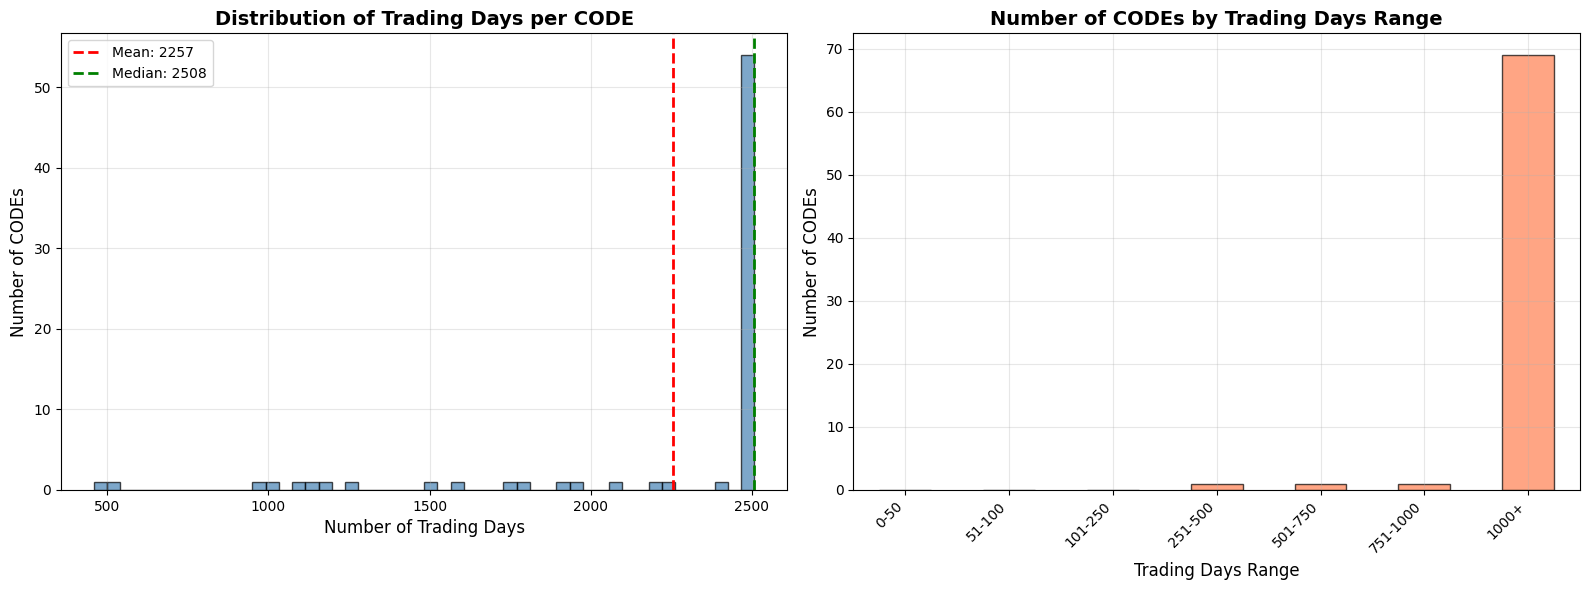

In [40]:
# Analyze how many trading days each CODE has been tracked
print("=" * 80)
print("TRADING DAYS PER CODE (TICKER) ANALYSIS")
print("=" * 80)

# Count unique SEANCE dates for each CODE
days_per_code = dataset.groupby('CODE')['SEANCE'].nunique().reset_index()
days_per_code.columns = ['CODE', 'Trading_Days']
days_per_code = days_per_code.sort_values('Trading_Days', ascending=False)

print(f"\nTotal unique CODEs: {len(days_per_code):,}")
print(f"\nTrading Days Statistics:")
print(f"  Mean: {days_per_code['Trading_Days'].mean():.2f} days")
print(f"  Median: {days_per_code['Trading_Days'].median():.0f} days")
print(f"  Min: {days_per_code['Trading_Days'].min()} days")
print(f"  Max: {days_per_code['Trading_Days'].max()} days")
print(f"  Std: {days_per_code['Trading_Days'].std():.2f} days")

print("\n" + "=" * 80)
print("TOP 10 MOST TRACKED CODES")
print("=" * 80)
display(days_per_code.head(10))

print("\n" + "=" * 80)
print("BOTTOM 10 LEAST TRACKED CODES")
print("=" * 80)
display(days_per_code.tail(10))

print("\n" + "=" * 80)
print("DISTRIBUTION OF TRADING DAYS")
print("=" * 80)

# Create bins for better understanding
bins = [0, 50, 100, 250, 500, 750, 1000, days_per_code['Trading_Days'].max() + 1]
labels = ['0-50', '51-100', '101-250', '251-500', '501-750', '751-1000', '1000+']
days_per_code['Days_Range'] = pd.cut(days_per_code['Trading_Days'], bins=bins, labels=labels, right=False)

distribution = days_per_code['Days_Range'].value_counts().sort_index()
print(distribution)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(days_per_code['Trading_Days'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Trading Days per CODE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Trading Days', fontsize=12)
axes[0].set_ylabel('Number of CODEs', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].axvline(days_per_code['Trading_Days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {days_per_code["Trading_Days"].mean():.0f}')
axes[0].axvline(days_per_code['Trading_Days'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {days_per_code["Trading_Days"].median():.0f}')
axes[0].legend()

# Bar chart of ranges
distribution.plot(kind='bar', ax=axes[1], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Number of CODEs by Trading Days Range', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Trading Days Range', fontsize=12)
axes[1].set_ylabel('Number of CODEs', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
print("CHECKING TICKERS TRACKED UNTIL END OF DATASET")

# Get the last date in the dataset
last_date = dataset['SEANCE'].max()
print(f"\nLast date in dataset: {last_date.date()}")

# For each CODE, get the last trading date
code_last_dates = dataset.groupby('CODE').agg({
    'SEANCE': ['min', 'max', 'nunique'],
    'VALEUR': 'first'
}).reset_index()

code_last_dates.columns = ['CODE', 'First_Date', 'Last_Date', 'Trading_Days', 'VALEUR']
code_last_dates = code_last_dates.sort_values('Last_Date', ascending=False)

# Split into active and inactive tickers - STRICT CHECK (must be on exact last date)
active_tickers = code_last_dates[code_last_dates['Last_Date'] == last_date]
inactive_tickers = code_last_dates[code_last_dates['Last_Date'] < last_date]

print("\nACTIVE TICKERS (Tracked until EXACT last date of dataset)")
print(f"\nTotal active tickers: {len(active_tickers)}")
print(f"\nStatistics for active tickers:")
print(f"  Mean trading days: {active_tickers['Trading_Days'].mean():.2f}")
print(f"  Median trading days: {active_tickers['Trading_Days'].median():.0f}")
print(f"  Min trading days: {active_tickers['Trading_Days'].min()}")
print(f"  Max trading days: {active_tickers['Trading_Days'].max()}")

# Check if any active tickers have old format codes
active_old_format = active_tickers[~active_tickers['CODE'].str.startswith('TN')]
print(f"\nActive tickers with OLD format codes: {len(active_old_format)}")
if len(active_old_format) > 0:
    print("\nWARNING: Found active tickers with old format codes:")
    display(active_old_format)

print("\nINACTIVE TICKERS (Stopped trading before last date)")
print(f"\nTotal inactive tickers: {len(inactive_tickers)}")
print(f"\nStatistics for inactive tickers:")
print(f"  Mean trading days: {inactive_tickers['Trading_Days'].mean():.2f}")
print(f"  Median trading days: {inactive_tickers['Trading_Days'].median():.0f}")
print(f"  Min trading days: {inactive_tickers['Trading_Days'].min()}")
print(f"  Max trading days: {inactive_tickers['Trading_Days'].max()}")

# Check old format codes in inactive tickers
inactive_old_format = inactive_tickers[~inactive_tickers['CODE'].str.startswith('TN')]
print(f"\nInactive tickers with OLD format codes: {len(inactive_old_format)}")

if len(inactive_old_format) > 0:
    print("\nInactive tickers with old format codes:")
    display(inactive_old_format[['CODE', 'VALEUR', 'First_Date', 'Last_Date', 'Trading_Days']])

print("\nBOTTOM 10 INACTIVE TICKERS (By Trading Days)")
display(inactive_tickers.nsmallest(20, 'Trading_Days')[['CODE', 'VALEUR', 'First_Date', 'Last_Date', 'Trading_Days']])

print("\nSUMMARY")
print(f"Total CODEs: {len(code_last_dates)}")
print(f"Active CODEs (tracked until {last_date.date()}): {len(active_tickers)} ({len(active_tickers)/len(code_last_dates)*100:.2f}%)")
print(f"Inactive CODEs: {len(inactive_tickers)} ({len(inactive_tickers)/len(code_last_dates)*100:.2f}%)")
print(f"\nOld format CODEs (not starting with 'TN'):")
print(f"  - Active: {len(active_old_format)}")
print(f"  - Inactive: {len(inactive_old_format)}")
print(f"  - Total: {len(active_old_format) + len(inactive_old_format)}")

CHECKING TICKERS TRACKED UNTIL END OF DATASET

Last date in dataset: 2025-12-31

ACTIVE TICKERS (Tracked until EXACT last date of dataset)

Total active tickers: 62

Statistics for active tickers:
  Mean trading days: 2366.66
  Median trading days: 2508
  Min trading days: 500
  Max trading days: 2508

Active tickers with OLD format codes: 0

INACTIVE TICKERS (Stopped trading before last date)

Total inactive tickers: 10

Statistics for inactive tickers:
  Mean trading days: 1574.50
  Median trading days: 1774
  Min trading days: 459
  Max trading days: 2181

Inactive tickers with OLD format codes: 3

Inactive tickers with old format codes:


,CODE,VALEUR,First_Date,Last_Date,Trading_Days
1,749001,HEXABYTE,2016-01-04,2020-09-29,1186
2,779001,TUNISIE VALEURS,2018-09-24,2020-07-24,459
0,330090,ELBENE,2016-01-04,2020-07-03,1127



BOTTOM 10 INACTIVE TICKERS (By Trading Days)


,CODE,VALEUR,First_Date,Last_Date,Trading_Days
2,779001,TUNISIE VALEURS,2018-09-24,2020-07-24,459
0,330090,ELBENE,2016-01-04,2020-07-03,1127
1,749001,HEXABYTE,2016-01-04,2020-09-29,1186
32,TN0006640015,STEQ,2016-01-04,2021-01-05,1253
41,TN0007250012,ADWYA,2016-01-04,2023-01-05,1760
63,TN0007640014,CEREALIS,2016-01-04,2023-02-13,1787
8,TN0001500859,AMS,2016-01-04,2023-09-15,1934
43,TN0007290018,SOPAT,2016-01-04,2023-11-03,1968
46,TN0007340011,SERVICOM,2016-01-04,2024-04-30,2090
33,TN0006650014,ELECTROSTAR,2016-01-04,2024-09-10,2181



SUMMARY
Total CODEs: 72
Active CODEs (tracked until 2025-12-31): 62 (86.11%)
Inactive CODEs: 10 (13.89%)

Old format CODEs (not starting with 'TN'):
  - Active: 0
  - Inactive: 3
  - Total: 3


In [42]:
print("DROPPING INACTIVE TICKERS FROM DATASET")

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique CODEs: {dataset['CODE'].nunique()}")

# Get list of active ticker CODEs
active_codes = active_tickers['CODE'].tolist()
print(f"\nActive CODEs to keep: {len(active_codes)}")

# Filter dataset to keep only active tickers
dataset = dataset[dataset['CODE'].isin(active_codes)]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nNew unique CODEs: {dataset['CODE'].nunique()}")
print(f"New unique VALEURs: {dataset['VALEUR'].nunique()}")

# Verify all remaining tickers are active
print("\nVERIFICATION")
final_last_dates = dataset.groupby('CODE')['SEANCE'].max()
all_active = (final_last_dates == last_date).all()

if all_active:
    print("SUCCESS: All remaining tickers are tracked until the last date")
else:
    print("WARNING: Some tickers may not be tracked until the last date")
    inactive_count = (final_last_dates < last_date).sum()
    print(f"Tickers not tracked until last date: {inactive_count}")

print("\nFINAL DATASET SUMMARY")
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Unique VALEURs: {dataset['VALEUR'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DROPPING INACTIVE TICKERS FROM DATASET

Original dataset shape: (162478, 11)
Original number of rows: 162,478
Original unique CODEs: 72

Active CODEs to keep: 62

Filtered dataset shape: (146733, 11)
New number of rows: 146,733
Rows removed: 15,745
Percentage of data removed: 9.69%

New unique CODEs: 62
New unique VALEURs: 62

VERIFICATION
SUCCESS: All remaining tickers are tracked until the last date

FINAL DATASET SUMMARY
Shape: (146733, 11)
Rows: 146,733
Unique CODEs: 62
Unique VALEURs: 62
Date range: 2016-01-04 to 2025-12-31
Memory usage: 28.25 MB


In [43]:
# Statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)

# Get numeric columns only
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {numeric_cols}")

if len(numeric_cols) > 0:
    display(dataset[numeric_cols].describe().T)
    
    # Additional statistics
    print("\n" + "=" * 60)
    print("ADDITIONAL STATISTICS")
    print("=" * 60)
    
    stats_df = pd.DataFrame({
        'Column': numeric_cols,
        'Mean': [dataset[col].mean() for col in numeric_cols],
        'Median': [dataset[col].median() for col in numeric_cols],
        'Std': [dataset[col].std() for col in numeric_cols],
        'Variance': [dataset[col].var() for col in numeric_cols],
        'Skewness': [dataset[col].skew() for col in numeric_cols],
        'Kurtosis': [dataset[col].kurtosis() for col in numeric_cols]
    })
    
    display(stats_df)
else:
    print("\nNo numeric columns found. Need to check data types.")

STATISTICAL SUMMARY

Numeric columns: ['GROUPE', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']


,count,mean,std,min,25%,50%,75%,max
GROUPE,146733.0,19.396864,23.514198,11.0,11.0,11.0,12.0,99.0
OUVERTURE,146733.0,15.09748,26.974373,0.0,1.98,6.35,14.67,237.9
CLOTURE,146733.0,15.982548,27.465098,0.0,2.32,7.0,15.6,242.42
PLUS_BAS,146733.0,12.843616,25.335434,0.0,0.51,4.79,12.55,242.42
PLUS_HAUT,146733.0,12.936743,25.5593,0.0,0.48,4.82,12.7,242.42
QUANTITE_NEGOCIEE,146733.0,12151.409363,164968.670065,0.0,4.0,772.0,5074.0,45862421.0
NB_TRANSACTION,146733.0,20.342159,41.936555,0.0,1.0,6.0,23.0,1420.0
CAPITAUX,146733.0,105656.111742,2493004.32432,0.0,23.8,5793.05,38126.41,802590290.5



ADDITIONAL STATISTICS


,Column,Mean,Median,Std,Variance,Skewness,Kurtosis
0,GROUPE,19.396864,11.00,2.351420e+01,5.529175e+02,2.806702,6.387768
1,OUVERTURE,15.097480,6.35,2.697437e+01,7.276168e+02,3.621838,15.242575
2,CLOTURE,15.982548,7.00,2.746510e+01,7.543316e+02,3.501444,14.163471
3,PLUS_BAS,12.843616,4.79,2.533543e+01,6.418842e+02,3.961043,18.300674
4,PLUS_HAUT,12.936743,4.82,2.555930e+01,6.532778e+02,3.971727,18.411341
5,QUANTITE_NEGOCIEE,12151.409363,772.00,1.649687e+05,2.721466e+10,167.032542,42045.167257
6,NB_TRANSACTION,20.342159,6.00,4.193656e+01,1.758675e+03,7.160176,101.477443
7,CAPITAUX,105656.111742,5793.05,2.493004e+06,6.215071e+12,239.345836,73870.241998


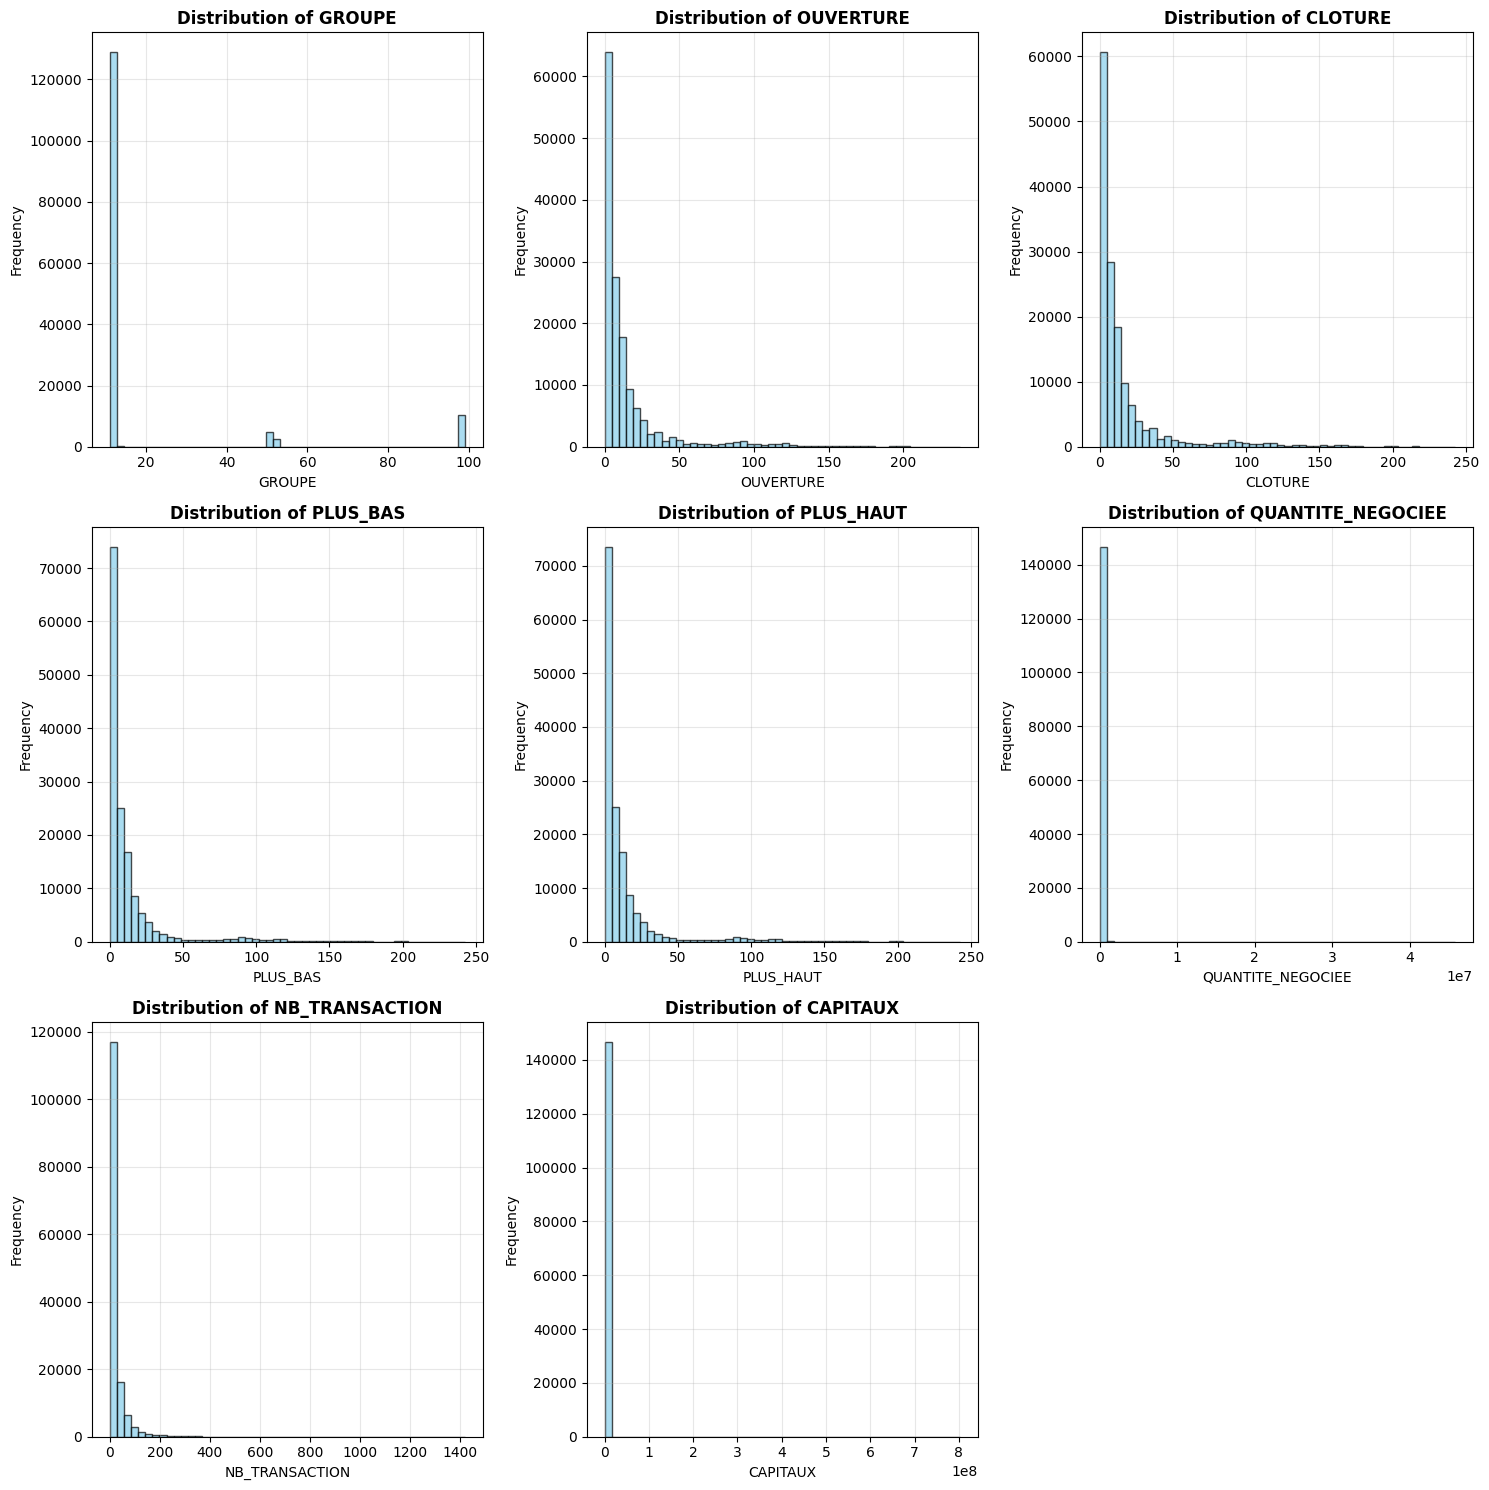

In [44]:
# Distribution plots for numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].hist(dataset[col].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns to plot.")

DISTRIBUTION ANALYSIS - NON-ZERO VALUES ONLY


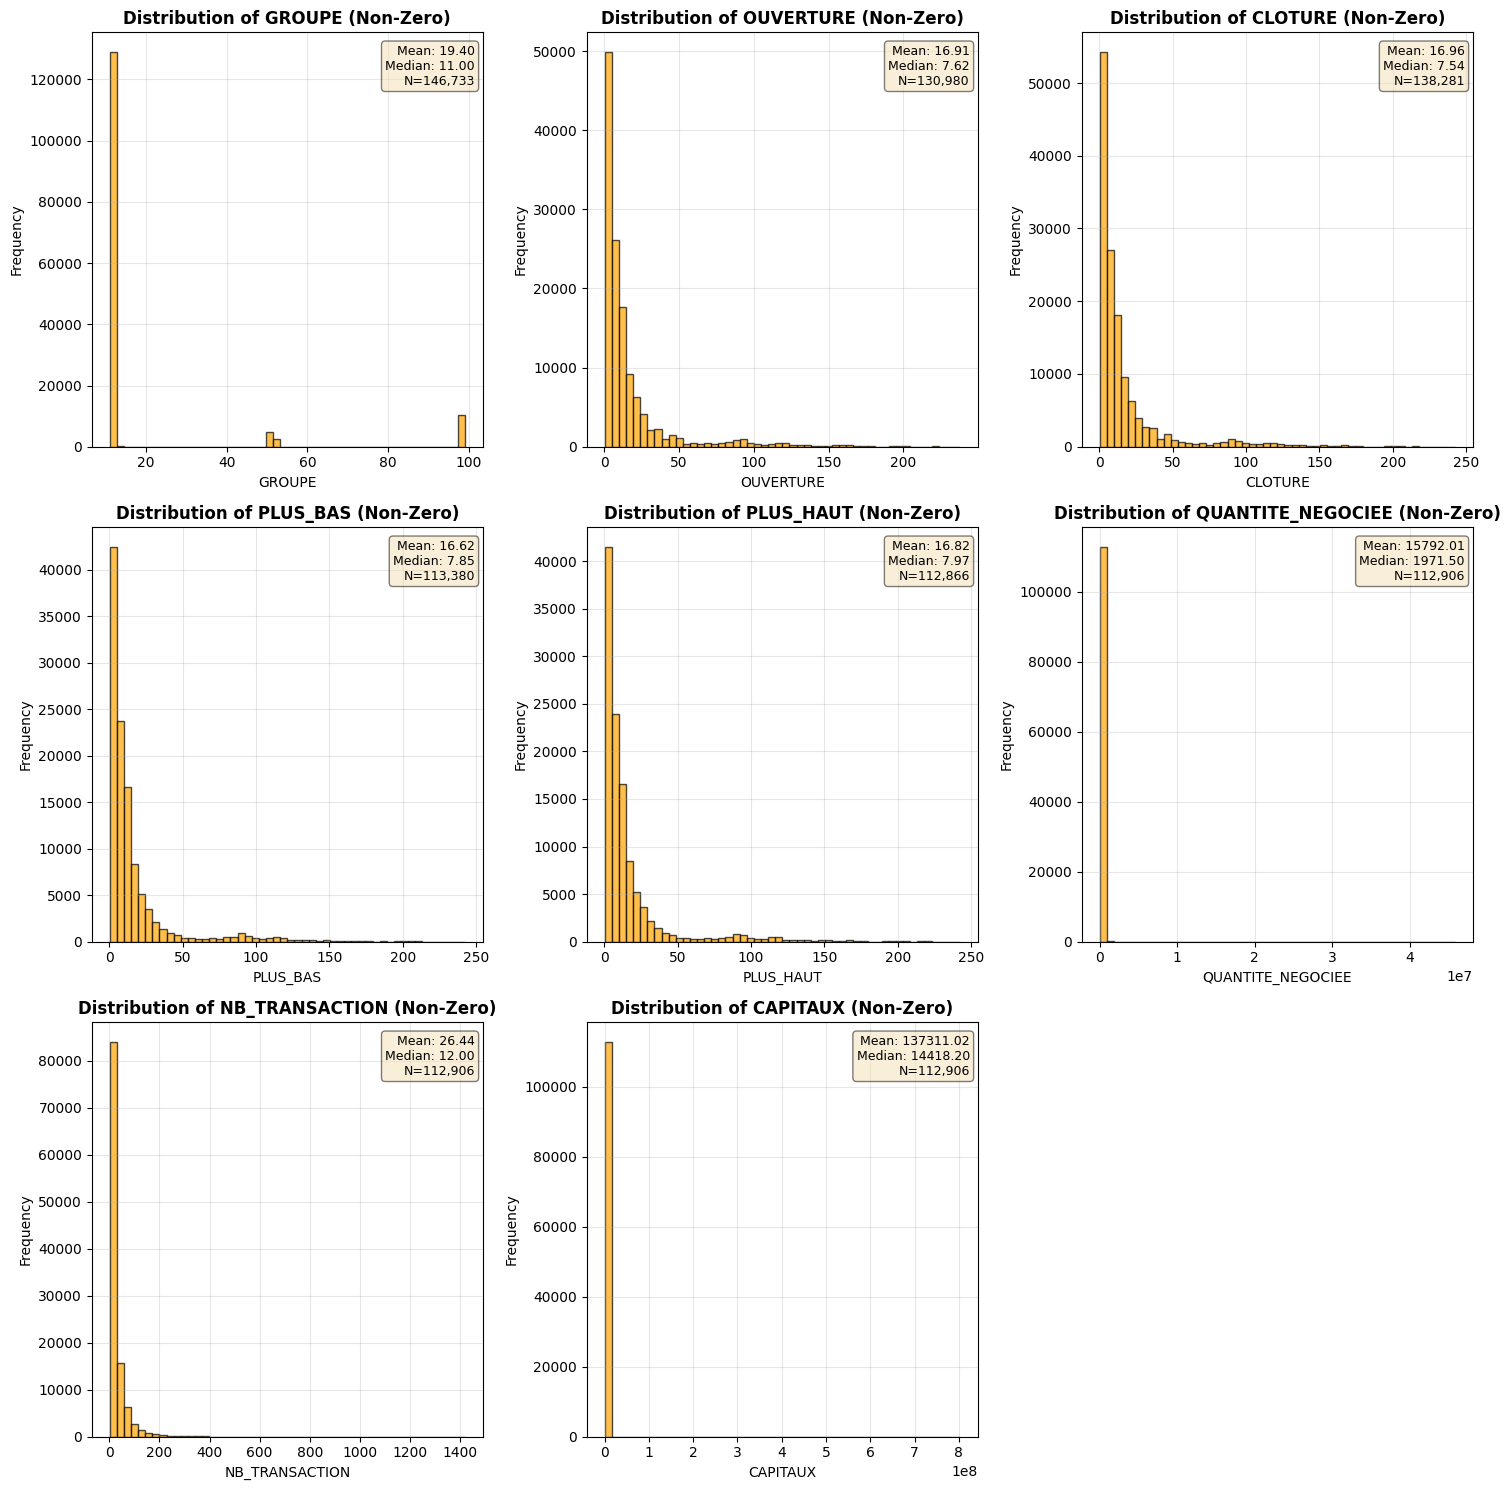


ZERO vs NON-ZERO VALUE STATISTICS


,Column,Total_Count,Zero_Count,Non_Zero_Count,Zero_Percentage
0,GROUPE,146733,0,146733,0.000000
1,OUVERTURE,146733,15753,130980,10.735826
2,CLOTURE,146733,8452,138281,5.760122
3,PLUS_BAS,146733,33353,113380,22.730401
4,PLUS_HAUT,146733,33867,112866,23.080698
5,QUANTITE_NEGOCIEE,146733,33827,112906,23.053437
6,NB_TRANSACTION,146733,33827,112906,23.053437
7,CAPITAUX,146733,33827,112906,23.053437


In [45]:
# Distribution plots for numeric columns (excluding zero values)
print("=" * 80)
print("DISTRIBUTION ANALYSIS - NON-ZERO VALUES ONLY")
print("=" * 80)

numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        # Filter out zero values
        non_zero_data = dataset[dataset[col] != 0][col].dropna()
        
        if len(non_zero_data) > 0:
            axes[idx].hist(non_zero_data, bins=50, color='orange', edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'Distribution of {col} (Non-Zero)', fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')
            axes[idx].grid(alpha=0.3)
            
            # Add statistics text
            mean_val = non_zero_data.mean()
            median_val = non_zero_data.median()
            stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nN={len(non_zero_data):,}'
            axes[idx].text(0.98, 0.97, stats_text, 
                          transform=axes[idx].transAxes,
                          verticalalignment='top',
                          horizontalalignment='right',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontsize=9)
        else:
            axes[idx].text(0.5, 0.5, f'No non-zero values\nfor {col}',
                          transform=axes[idx].transAxes,
                          ha='center', va='center',
                          fontsize=12, color='red')
            axes[idx].set_title(f'Distribution of {col} (Non-Zero)', fontweight='bold')
    
    # Hide empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics about zero vs non-zero values
    print("\n" + "=" * 80)
    print("ZERO vs NON-ZERO VALUE STATISTICS")
    print("=" * 80)
    
    zero_stats = pd.DataFrame({
        'Column': numeric_cols,
        'Total_Count': [len(dataset[col].dropna()) for col in numeric_cols],
        'Zero_Count': [len(dataset[dataset[col] == 0][col]) for col in numeric_cols],
        'Non_Zero_Count': [len(dataset[dataset[col] != 0][col].dropna()) for col in numeric_cols],
        'Zero_Percentage': [(len(dataset[dataset[col] == 0][col]) / len(dataset[col].dropna()) * 100) 
                            if len(dataset[col].dropna()) > 0 else 0 for col in numeric_cols]
    })
    
    display(zero_stats)
else:
    print("No numeric columns to plot.")

TRADING DATA VALIDATION ANALYSIS

Validation Rules:
  1. CLOTURE > 0
  2. PLUS_HAUT >= max(OUVERTURE, CLOTURE)
  3. PLUS_BAS <= min(OUVERTURE, CLOTURE)

A row is VALID only if ALL three conditions are met.

OVERALL VALIDATION STATISTICS
Total rows: 146,733
Valid rows: 89,350 (60.89%)
Invalid rows: 57,383 (39.11%)

PER-TICKER VALIDATION STATISTICS

Total tickers analyzed: 62

Invalid Days Statistics:
  Mean: 40.22%
  Median: 34.33%
  Min: 10.81%
  Max: 86.76%
  Std: 22.53%

TOP 20 TICKERS WITH HIGHEST INVALID PERCENTAGE


,VALEUR,Total_Days,Valid_Days,Invalid_Days,Invalid_Percentage,CLOTURE_Fail,PLUS_HAUT_Fail,PLUS_BAS_Fail
43,ASTREE,2508,332,2176,86.762360,630,1495,75
56,BH ASSURANCE,1574,234,1340,85.133418,141,1178,44
53,STIP,2508,446,2062,82.216906,548,1307,230
47,BEST LEASE,2508,504,2004,79.904306,524,1381,119
55,SANIMED,2247,529,1718,76.457499,293,1309,140
51,SOTEMAIL,2508,619,1889,75.318979,384,1456,70
57,BH LEASING,1484,388,1096,73.854447,136,660,327
42,UBCI,2508,717,1791,71.411483,492,1121,194
61,BNA ASSURANCES,500,147,353,70.600000,1,201,153
46,SIPHAT,2508,741,1767,70.454545,374,1209,205



TOP 20 TICKERS WITH LOWEST INVALID PERCENTAGE


,VALEUR,Total_Days,Valid_Days,Invalid_Days,Invalid_Percentage,CLOTURE_Fail,PLUS_HAUT_Fail,PLUS_BAS_Fail
8,UIB,2508,1934,574,22.886762,7,432,141
36,SOTIPAPIER,2508,2001,507,20.215311,28,319,162
37,DELICE HOLDING,2508,2007,501,19.976077,55,338,110
24,ARTES,2508,2012,496,19.776715,23,299,177
15,SOTUMAG,2508,2022,486,19.377990,20,300,168
54,UNIMED,2426,1956,470,19.373454,15,386,72
13,SOTETEL,2508,2027,481,19.178628,35,368,84
29,TELNET HOLDING,2508,2052,456,18.181818,11,264,186
6,STB BANK,2508,2054,454,18.102073,21,376,59
7,AMEN BANK,2508,2058,450,17.942584,21,315,118



TICKERS WITH 100% VALID DATA: 0

TICKERS WITH >50% INVALID DATA: 21


,VALEUR,Total_Days,Valid_Days,Invalid_Days,Invalid_Percentage,CLOTURE_Fail,PLUS_HAUT_Fail,PLUS_BAS_Fail
43,ASTREE,2508,332,2176,86.762360,630,1495,75
56,BH ASSURANCE,1574,234,1340,85.133418,141,1178,44
53,STIP,2508,446,2062,82.216906,548,1307,230
47,BEST LEASE,2508,504,2004,79.904306,524,1381,119
55,SANIMED,2247,529,1718,76.457499,293,1309,140
51,SOTEMAIL,2508,619,1889,75.318979,384,1456,70
57,BH LEASING,1484,388,1096,73.854447,136,660,327
42,UBCI,2508,717,1791,71.411483,492,1121,194
61,BNA ASSURANCES,500,147,353,70.600000,1,201,153
46,SIPHAT,2508,741,1767,70.454545,374,1209,205


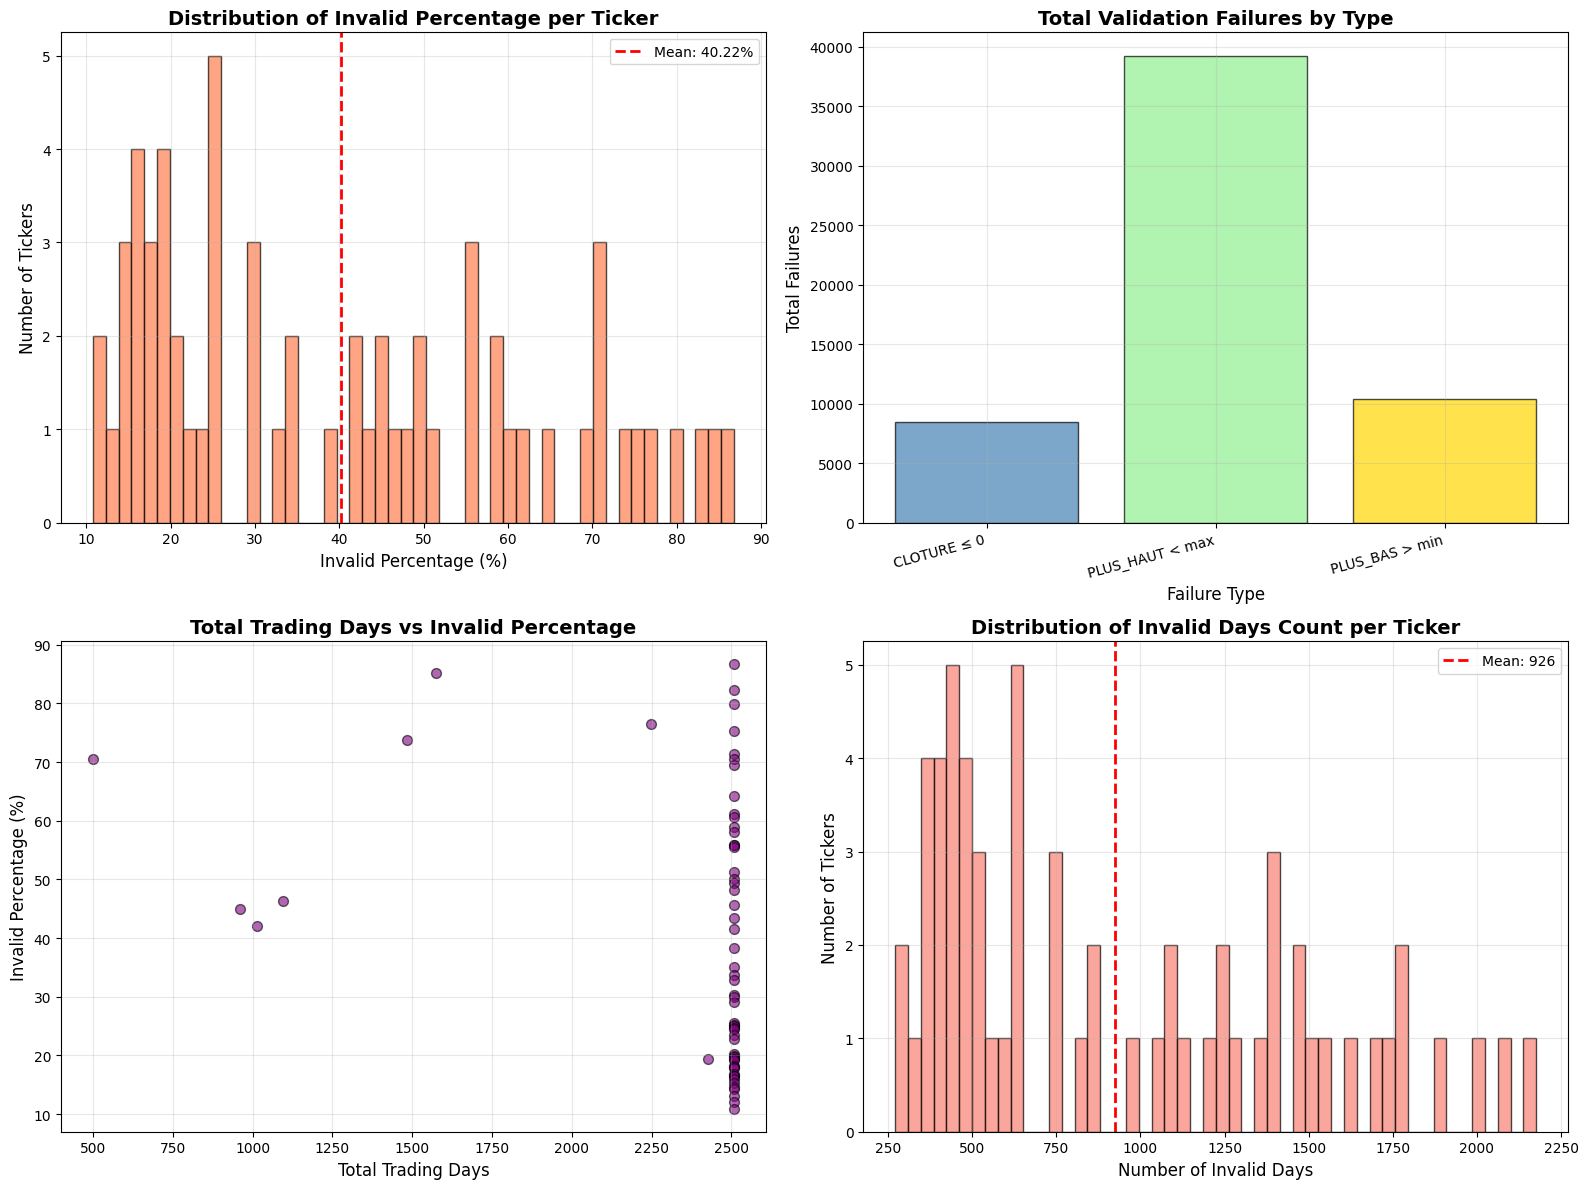


VALIDATION ANALYSIS COMPLETE

Validation DataFrame stored as 'ticker_validation_df'
Dataset now includes 'is_valid' column


In [46]:
print("=" * 80)
print("TRADING DATA VALIDATION ANALYSIS")
print("=" * 80)

print("\nValidation Rules:")
print("  1. CLOTURE > 0")
print("  2. PLUS_HAUT >= max(OUVERTURE, CLOTURE)")
print("  3. PLUS_BAS <= min(OUVERTURE, CLOTURE)")
print("\nA row is VALID only if ALL three conditions are met.")

# Create validation flags
dataset['is_valid'] = (
    (dataset['CLOTURE'] > 0) &
    (dataset['PLUS_HAUT'] >= dataset[['OUVERTURE', 'CLOTURE']].max(axis=1)) &
    (dataset['PLUS_BAS'] <= dataset[['OUVERTURE', 'CLOTURE']].min(axis=1))
)

# Overall validation statistics
total_rows = len(dataset)
valid_rows = dataset['is_valid'].sum()
invalid_rows = total_rows - valid_rows

print("\n" + "=" * 80)
print("OVERALL VALIDATION STATISTICS")
print("=" * 80)
print(f"Total rows: {total_rows:,}")
print(f"Valid rows: {valid_rows:,} ({valid_rows/total_rows*100:.2f}%)")
print(f"Invalid rows: {invalid_rows:,} ({invalid_rows/total_rows*100:.2f}%)")

# Per-ticker validation analysis
ticker_validation = []

for ticker in dataset['VALEUR'].unique():
    ticker_data = dataset[dataset['VALEUR'] == ticker]
    
    total_days = len(ticker_data)
    valid_days = ticker_data['is_valid'].sum()
    invalid_days = total_days - valid_days
    invalid_pct = (invalid_days / total_days) * 100 if total_days > 0 else 0
    
    # Breakdown of which conditions fail
    cloture_fail = (ticker_data['CLOTURE'] <= 0).sum()
    plus_haut_fail = (ticker_data['PLUS_HAUT'] < ticker_data[['OUVERTURE', 'CLOTURE']].max(axis=1)).sum()
    plus_bas_fail = (ticker_data['PLUS_BAS'] > ticker_data[['OUVERTURE', 'CLOTURE']].min(axis=1)).sum()
    
    ticker_validation.append({
        'VALEUR': ticker,
        'Total_Days': total_days,
        'Valid_Days': valid_days,
        'Invalid_Days': invalid_days,
        'Invalid_Percentage': invalid_pct,
        'CLOTURE_Fail': cloture_fail,
        'PLUS_HAUT_Fail': plus_haut_fail,
        'PLUS_BAS_Fail': plus_bas_fail
    })

ticker_validation_df = pd.DataFrame(ticker_validation)
ticker_validation_df = ticker_validation_df.sort_values('Invalid_Percentage', ascending=False)

print("\n" + "=" * 80)
print("PER-TICKER VALIDATION STATISTICS")
print("=" * 80)

print(f"\nTotal tickers analyzed: {len(ticker_validation_df)}")
print(f"\nInvalid Days Statistics:")
print(f"  Mean: {ticker_validation_df['Invalid_Percentage'].mean():.2f}%")
print(f"  Median: {ticker_validation_df['Invalid_Percentage'].median():.2f}%")
print(f"  Min: {ticker_validation_df['Invalid_Percentage'].min():.2f}%")
print(f"  Max: {ticker_validation_df['Invalid_Percentage'].max():.2f}%")
print(f"  Std: {ticker_validation_df['Invalid_Percentage'].std():.2f}%")

print("\n" + "=" * 80)
print("TOP 20 TICKERS WITH HIGHEST INVALID PERCENTAGE")
print("=" * 80)
display(ticker_validation_df.head(20))

print("\n" + "=" * 80)
print("TOP 20 TICKERS WITH LOWEST INVALID PERCENTAGE")
print("=" * 80)
display(ticker_validation_df.tail(20))

# Tickers with 100% valid data
perfect_tickers = ticker_validation_df[ticker_validation_df['Invalid_Percentage'] == 0]
print("\n" + "=" * 80)
print(f"TICKERS WITH 100% VALID DATA: {len(perfect_tickers)}")
print("=" * 80)
if len(perfect_tickers) > 0:
    display(perfect_tickers)

# Tickers with >50% invalid data
highly_invalid = ticker_validation_df[ticker_validation_df['Invalid_Percentage'] > 50]
print("\n" + "=" * 80)
print(f"TICKERS WITH >50% INVALID DATA: {len(highly_invalid)}")
print("=" * 80)
if len(highly_invalid) > 0:
    display(highly_invalid)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of invalid percentages
axes[0, 0].hist(ticker_validation_df['Invalid_Percentage'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Invalid Percentage per Ticker', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Invalid Percentage (%)', fontsize=12)
axes[0, 0].set_ylabel('Number of Tickers', fontsize=12)
axes[0, 0].axvline(ticker_validation_df['Invalid_Percentage'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ticker_validation_df["Invalid_Percentage"].mean():.2f}%')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Bar chart - validation failure types
failure_types = ['CLOTURE_Fail', 'PLUS_HAUT_Fail', 'PLUS_BAS_Fail']
failure_counts = [ticker_validation_df[fail_type].sum() for fail_type in failure_types]
axes[0, 1].bar(range(len(failure_types)), failure_counts, color=['steelblue', 'lightgreen', 'gold'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Total Validation Failures by Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Failure Type', fontsize=12)
axes[0, 1].set_ylabel('Total Failures', fontsize=12)
axes[0, 1].set_xticks(range(len(failure_types)))
axes[0, 1].set_xticklabels(['CLOTURE ≤ 0', 'PLUS_HAUT < max', 'PLUS_BAS > min'], rotation=15, ha='right')
axes[0, 1].grid(alpha=0.3)

# 3. Scatter plot - Total days vs Invalid percentage
axes[1, 0].scatter(ticker_validation_df['Total_Days'], ticker_validation_df['Invalid_Percentage'], 
                   alpha=0.6, c='purple', edgecolors='black', s=50)
axes[1, 0].set_title('Total Trading Days vs Invalid Percentage', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Trading Days', fontsize=12)
axes[1, 0].set_ylabel('Invalid Percentage (%)', fontsize=12)
axes[1, 0].grid(alpha=0.3)

# 4. Distribution of invalid days (absolute count)
axes[1, 1].hist(ticker_validation_df['Invalid_Days'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Invalid Days Count per Ticker', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Invalid Days', fontsize=12)
axes[1, 1].set_ylabel('Number of Tickers', fontsize=12)
axes[1, 1].axvline(ticker_validation_df['Invalid_Days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ticker_validation_df["Invalid_Days"].mean():.0f}')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("VALIDATION ANALYSIS COMPLETE")
print("=" * 80)
print("\nValidation DataFrame stored as 'ticker_validation_df'")
print("Dataset now includes 'is_valid' column")

dataset = dataset.drop('is_valid', axis=1)

In [47]:
print("=" * 80)
print("DROPPING TICKERS WITH >50% INVALID DATA")
print("=" * 80)

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique tickers: {dataset['VALEUR'].nunique()}")

# Get tickers with >50% invalid data from ticker_validation_df
highly_invalid_tickers = ticker_validation_df[ticker_validation_df['Invalid_Percentage'] > 50]['VALEUR'].tolist()

print(f"\nTickers with >50% invalid data: {len(highly_invalid_tickers)}")
print("\nTickers to be removed:")
for ticker in highly_invalid_tickers:
    invalid_pct = ticker_validation_df[ticker_validation_df['VALEUR'] == ticker]['Invalid_Percentage'].values[0]
    print(f"  - {ticker}: {invalid_pct:.2f}% invalid")

# Filter out rows for these tickers
dataset = dataset[~dataset['VALEUR'].isin(highly_invalid_tickers)]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print("\n" + "=" * 80)
print("REMOVAL SUMMARY")
print("=" * 80)
print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nNew unique tickers (VALEUR): {dataset['VALEUR'].nunique()}")
print(f"Tickers removed: {original_shape[0] - new_shape[0]}")

# Verify removal
remaining_invalid = dataset[dataset['VALEUR'].isin(highly_invalid_tickers)]
if len(remaining_invalid) == 0:
    print("\n✓ SUCCESS: All highly invalid tickers have been removed!")
else:
    print(f"\n⚠ WARNING: {len(remaining_invalid)} rows from invalid tickers still remain")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Optional: Update ticker_validation_df to reflect removal
print("\n" + "=" * 80)
print("UPDATING VALIDATION DATAFRAME")
print("=" * 80)

ticker_validation_df = ticker_validation_df[~ticker_validation_df['VALEUR'].isin(highly_invalid_tickers)]
print(f"Remaining tickers in validation df: {len(ticker_validation_df)}")
print(f"\nNew validation statistics:")
print(f"  Mean invalid %: {ticker_validation_df['Invalid_Percentage'].mean():.2f}%")
print(f"  Median invalid %: {ticker_validation_df['Invalid_Percentage'].median():.2f}%")
print(f"  Max invalid %: {ticker_validation_df['Invalid_Percentage'].max():.2f}%")

DROPPING TICKERS WITH >50% INVALID DATA

Original dataset shape: (146733, 11)
Original number of rows: 146,733
Original unique tickers: 62

Tickers with >50% invalid data: 21

Tickers to be removed:
  - ASTREE: 86.76% invalid
  - BH ASSURANCE: 85.13% invalid
  - STIP: 82.22% invalid
  - BEST LEASE: 79.90% invalid
  - SANIMED: 76.46% invalid
  - SOTEMAIL: 75.32% invalid
  - BH LEASING: 73.85% invalid
  - UBCI: 71.41% invalid
  - BNA ASSURANCES: 70.60% invalid
  - SIPHAT: 70.45% invalid
  - SIMPAR: 69.54% invalid
  - HANNIBAL LEASE: 64.23% invalid
  - AETECH: 61.12% invalid
  - SITS: 60.61% invalid
  - BTE (ADP): 58.93% invalid
  - MAGASIN GENERAL: 58.17% invalid
  - CIMENTS DE BIZERTE: 55.90% invalid
  - CIL: 55.86% invalid
  - AIR LIQUIDE TUNISIE: 55.54% invalid
  - STAR: 51.36% invalid
  - CELLCOM: 50.12% invalid

REMOVAL SUMMARY

Filtered dataset shape: (98292, 11)
New number of rows: 98,292
Rows removed: 48,441
Percentage of data removed: 33.01%

New unique tickers (VALEUR): 41
Tick

In [48]:
print("=" * 80)
print("DROPPING ROWS WITH CLOTURE = 0")
print("=" * 80)

# Store original shape
original_shape = dataset.shape
print(f"\nOriginal dataset shape: {original_shape}")
print(f"Original number of rows: {original_shape[0]:,}")
print(f"Original unique tickers: {dataset['VALEUR'].nunique()}")

# Count rows with CLOTURE = 0
zero_cloture_rows = (dataset['CLOTURE'] == 0).sum()
zero_cloture_pct = (zero_cloture_rows / len(dataset)) * 100

print(f"\nRows with CLOTURE = 0: {zero_cloture_rows:,} ({zero_cloture_pct:.2f}%)")

# Show breakdown by ticker
print("\n" + "=" * 80)
print("ZERO CLOTURE BREAKDOWN BY TICKER")
print("=" * 80)

zero_by_ticker = dataset[dataset['CLOTURE'] == 0].groupby('VALEUR').size().reset_index(name='Zero_Count')
zero_by_ticker = zero_by_ticker.sort_values('Zero_Count', ascending=False)

if len(zero_by_ticker) > 0:
    print(f"\nTickers affected: {len(zero_by_ticker)}")
    print("\nTop 10 tickers with most zero CLOTURE rows:")
    display(zero_by_ticker.head(10))
else:
    print("\nNo tickers with zero CLOTURE found.")

# Filter out rows where CLOTURE = 0
dataset = dataset[dataset['CLOTURE'] > 0]

# New shape after filtering
new_shape = dataset.shape
rows_removed = original_shape[0] - new_shape[0]

print("\n" + "=" * 80)
print("REMOVAL SUMMARY")
print("=" * 80)
print(f"\nFiltered dataset shape: {new_shape}")
print(f"New number of rows: {new_shape[0]:,}")
print(f"Rows removed: {rows_removed:,}")
print(f"Percentage of data removed: {(rows_removed/original_shape[0])*100:.2f}%")

print(f"\nRemaining unique tickers: {dataset['VALEUR'].nunique()}")

# Verify removal
remaining_zero_cloture = (dataset['CLOTURE'] == 0).sum()
if remaining_zero_cloture == 0:
    print("\n✓ SUCCESS: All rows with CLOTURE = 0 have been removed!")
else:
    print(f"\n⚠ WARNING: {remaining_zero_cloture} rows with CLOTURE = 0 still remain")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Unique CODEs: {dataset['CODE'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")
print(f"Memory usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update statistics
print("\n" + "=" * 80)
print("CLOTURE STATISTICS AFTER CLEANUP")
print("=" * 80)
print(f"Min CLOTURE: {dataset['CLOTURE'].min():.2f}")
print(f"Max CLOTURE: {dataset['CLOTURE'].max():.2f}")
print(f"Mean CLOTURE: {dataset['CLOTURE'].mean():.2f}")
print(f"Median CLOTURE: {dataset['CLOTURE'].median():.2f}")

DROPPING ROWS WITH CLOTURE = 0

Original dataset shape: (98292, 11)
Original number of rows: 98,292
Original unique tickers: 41

Rows with CLOTURE = 0: 2,133 (2.17%)

ZERO CLOTURE BREAKDOWN BY TICKER

Tickers affected: 41

Top 10 tickers with most zero CLOTURE rows:


,VALEUR,Zero_Count
29,SPDIT - SICAF,304
13,ICF,261
4,ATTIJARI LEASING,223
11,ESSOUKNA,173
37,TUNISIE LEASING & FACTORING,145
16,NEW BODY LINE,122
26,SOTRAPIL,87
35,TUNIS RE,75
8,CITY CARS,71
15,MPBS,70



REMOVAL SUMMARY

Filtered dataset shape: (96159, 11)
New number of rows: 96,159
Rows removed: 2,133
Percentage of data removed: 2.17%

Remaining unique tickers: 41

✓ SUCCESS: All rows with CLOTURE = 0 have been removed!

FINAL DATASET SUMMARY
Shape: (96159, 11)
Rows: 96,159
Unique tickers: 41
Unique CODEs: 41
Date range: 2016-01-04 to 2025-12-31
Memory usage: 18.52 MB

CLOTURE STATISTICS AFTER CLEANUP
Min CLOTURE: 0.21
Max CLOTURE: 222.90
Mean CLOTURE: 14.08
Median CLOTURE: 8.15


In [49]:
print("=" * 80)
print("FIXING PLUS_HAUT AND PLUS_BAS VALUES")
print("=" * 80)

# Calculate max(OUVERTURE, CLOTURE) and min(OUVERTURE, CLOTURE)
dataset['max_oc'] = dataset[['OUVERTURE', 'CLOTURE']].max(axis=1)
dataset['min_oc'] = dataset[['OUVERTURE', 'CLOTURE']].min(axis=1)

# Identify rows that need correction
plus_haut_invalid = dataset['PLUS_HAUT'] < dataset['max_oc']
plus_bas_invalid = dataset['PLUS_BAS'] > dataset['min_oc']

# Count invalid rows before correction
plus_haut_issues = plus_haut_invalid.sum()
plus_bas_issues = plus_bas_invalid.sum()
total_issues = (plus_haut_invalid | plus_bas_invalid).sum()

print(f"\nRows with issues BEFORE correction:")
print(f"  PLUS_HAUT < max(OUVERTURE, CLOTURE): {plus_haut_issues:,} ({plus_haut_issues/len(dataset)*100:.2f}%)")
print(f"  PLUS_BAS > min(OUVERTURE, CLOTURE): {plus_bas_issues:,} ({plus_bas_issues/len(dataset)*100:.2f}%)")
print(f"  Total rows with at least one issue: {total_issues:,} ({total_issues/len(dataset)*100:.2f}%)")

# Show examples before correction
if total_issues > 0:
    print("\n" + "=" * 80)
    print("EXAMPLES BEFORE CORRECTION (First 5 rows with issues)")
    print("=" * 80)
    issues_df = dataset[plus_haut_invalid | plus_bas_invalid][['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS', 'max_oc', 'min_oc']].head()
    display(issues_df)

# Apply corrections
print("\n" + "=" * 80)
print("APPLYING CORRECTIONS")
print("=" * 80)

# Fix PLUS_HAUT: set to max(OUVERTURE, CLOTURE) if it's less
dataset.loc[plus_haut_invalid, 'PLUS_HAUT'] = dataset.loc[plus_haut_invalid, 'max_oc']
print(f"✓ Fixed {plus_haut_issues:,} PLUS_HAUT values")

# Fix PLUS_BAS: set to min(OUVERTURE, CLOTURE) if it's greater
dataset.loc[plus_bas_invalid, 'PLUS_BAS'] = dataset.loc[plus_bas_invalid, 'min_oc']
print(f"✓ Fixed {plus_bas_issues:,} PLUS_BAS values")

# Verify corrections
print("\n" + "=" * 80)
print("VERIFICATION AFTER CORRECTION")
print("=" * 80)

plus_haut_still_invalid = (dataset['PLUS_HAUT'] < dataset['max_oc']).sum()
plus_bas_still_invalid = (dataset['PLUS_BAS'] > dataset['min_oc']).sum()
total_still_invalid = ((dataset['PLUS_HAUT'] < dataset['max_oc']) | (dataset['PLUS_BAS'] > dataset['min_oc'])).sum()

print(f"\nRows with issues AFTER correction:")
print(f"  PLUS_HAUT < max(OUVERTURE, CLOTURE): {plus_haut_still_invalid:,}")
print(f"  PLUS_BAS > min(OUVERTURE, CLOTURE): {plus_bas_still_invalid:,}")
print(f"  Total rows with at least one issue: {total_still_invalid:,}")

if total_still_invalid == 0:
    print("\n✓ SUCCESS: All PLUS_HAUT and PLUS_BAS values are now valid!")
else:
    print(f"\n⚠ WARNING: {total_still_invalid} rows still have issues")

# Show examples after correction (same rows as before)
if total_issues > 0:
    print("\n" + "=" * 80)
    print("EXAMPLES AFTER CORRECTION (Same rows as before)")
    print("=" * 80)
    # Get the same indices as before
    issue_indices = dataset[plus_haut_invalid | plus_bas_invalid].head().index
    corrected_df = dataset.loc[issue_indices, ['SEANCE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_HAUT', 'PLUS_BAS', 'max_oc', 'min_oc']]
    display(corrected_df)

# Clean up temporary columns
dataset = dataset.drop(columns=['max_oc', 'min_oc'])

print("\n" + "=" * 80)
print("CORRECTION SUMMARY")
print("=" * 80)
print(f"Total rows corrected: {total_issues:,}")
print(f"PLUS_HAUT corrections: {plus_haut_issues:,}")
print(f"PLUS_BAS corrections: {plus_bas_issues:,}")
print(f"Percentage of data corrected: {total_issues/len(dataset)*100:.2f}%")

print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Shape: {dataset.shape}")
print(f"Rows: {dataset.shape[0]:,}")
print(f"Unique tickers: {dataset['VALEUR'].nunique()}")
print(f"Date range: {dataset['SEANCE'].min().date()} to {dataset['SEANCE'].max().date()}")

FIXING PLUS_HAUT AND PLUS_BAS VALUES

Rows with issues BEFORE correction:
  PLUS_HAUT < max(OUVERTURE, CLOTURE): 16,487 (17.15%)
  PLUS_BAS > min(OUVERTURE, CLOTURE): 6,691 (6.96%)
  Total rows with at least one issue: 22,968 (23.89%)

EXAMPLES BEFORE CORRECTION (First 5 rows with issues)


,SEANCE,VALEUR,OUVERTURE,CLOTURE,PLUS_HAUT,PLUS_BAS,max_oc,min_oc
259755,2018-01-02,ASSAD,0.0,9.00,0.0,0.0,9.00,0.0
259801,2018-01-02,UNIMED,0.0,7.85,0.0,0.0,7.85,0.0
259811,2018-01-02,ICF,0.0,28.13,0.0,0.0,28.13,0.0
259815,2018-01-02,SPDIT - SICAF,0.0,8.20,0.0,0.0,8.20,0.0
260405,2018-01-04,SPDIT - SICAF,0.0,8.10,0.0,0.0,8.10,0.0



APPLYING CORRECTIONS
✓ Fixed 16,487 PLUS_HAUT values
✓ Fixed 6,691 PLUS_BAS values

VERIFICATION AFTER CORRECTION

Rows with issues AFTER correction:
  PLUS_HAUT < max(OUVERTURE, CLOTURE): 0
  PLUS_BAS > min(OUVERTURE, CLOTURE): 0
  Total rows with at least one issue: 0

✓ SUCCESS: All PLUS_HAUT and PLUS_BAS values are now valid!

EXAMPLES AFTER CORRECTION (Same rows as before)


,SEANCE,VALEUR,OUVERTURE,CLOTURE,PLUS_HAUT,PLUS_BAS,max_oc,min_oc
259755,2018-01-02,ASSAD,0.0,9.00,9.00,0.0,9.00,0.0
259801,2018-01-02,UNIMED,0.0,7.85,7.85,0.0,7.85,0.0
259811,2018-01-02,ICF,0.0,28.13,28.13,0.0,28.13,0.0
259815,2018-01-02,SPDIT - SICAF,0.0,8.20,8.20,0.0,8.20,0.0
260405,2018-01-04,SPDIT - SICAF,0.0,8.10,8.10,0.0,8.10,0.0



CORRECTION SUMMARY
Total rows corrected: 22,968
PLUS_HAUT corrections: 16,487
PLUS_BAS corrections: 6,691
Percentage of data corrected: 23.89%

FINAL DATASET SUMMARY
Shape: (96159, 11)
Rows: 96,159
Unique tickers: 41
Date range: 2016-01-04 to 2025-12-31


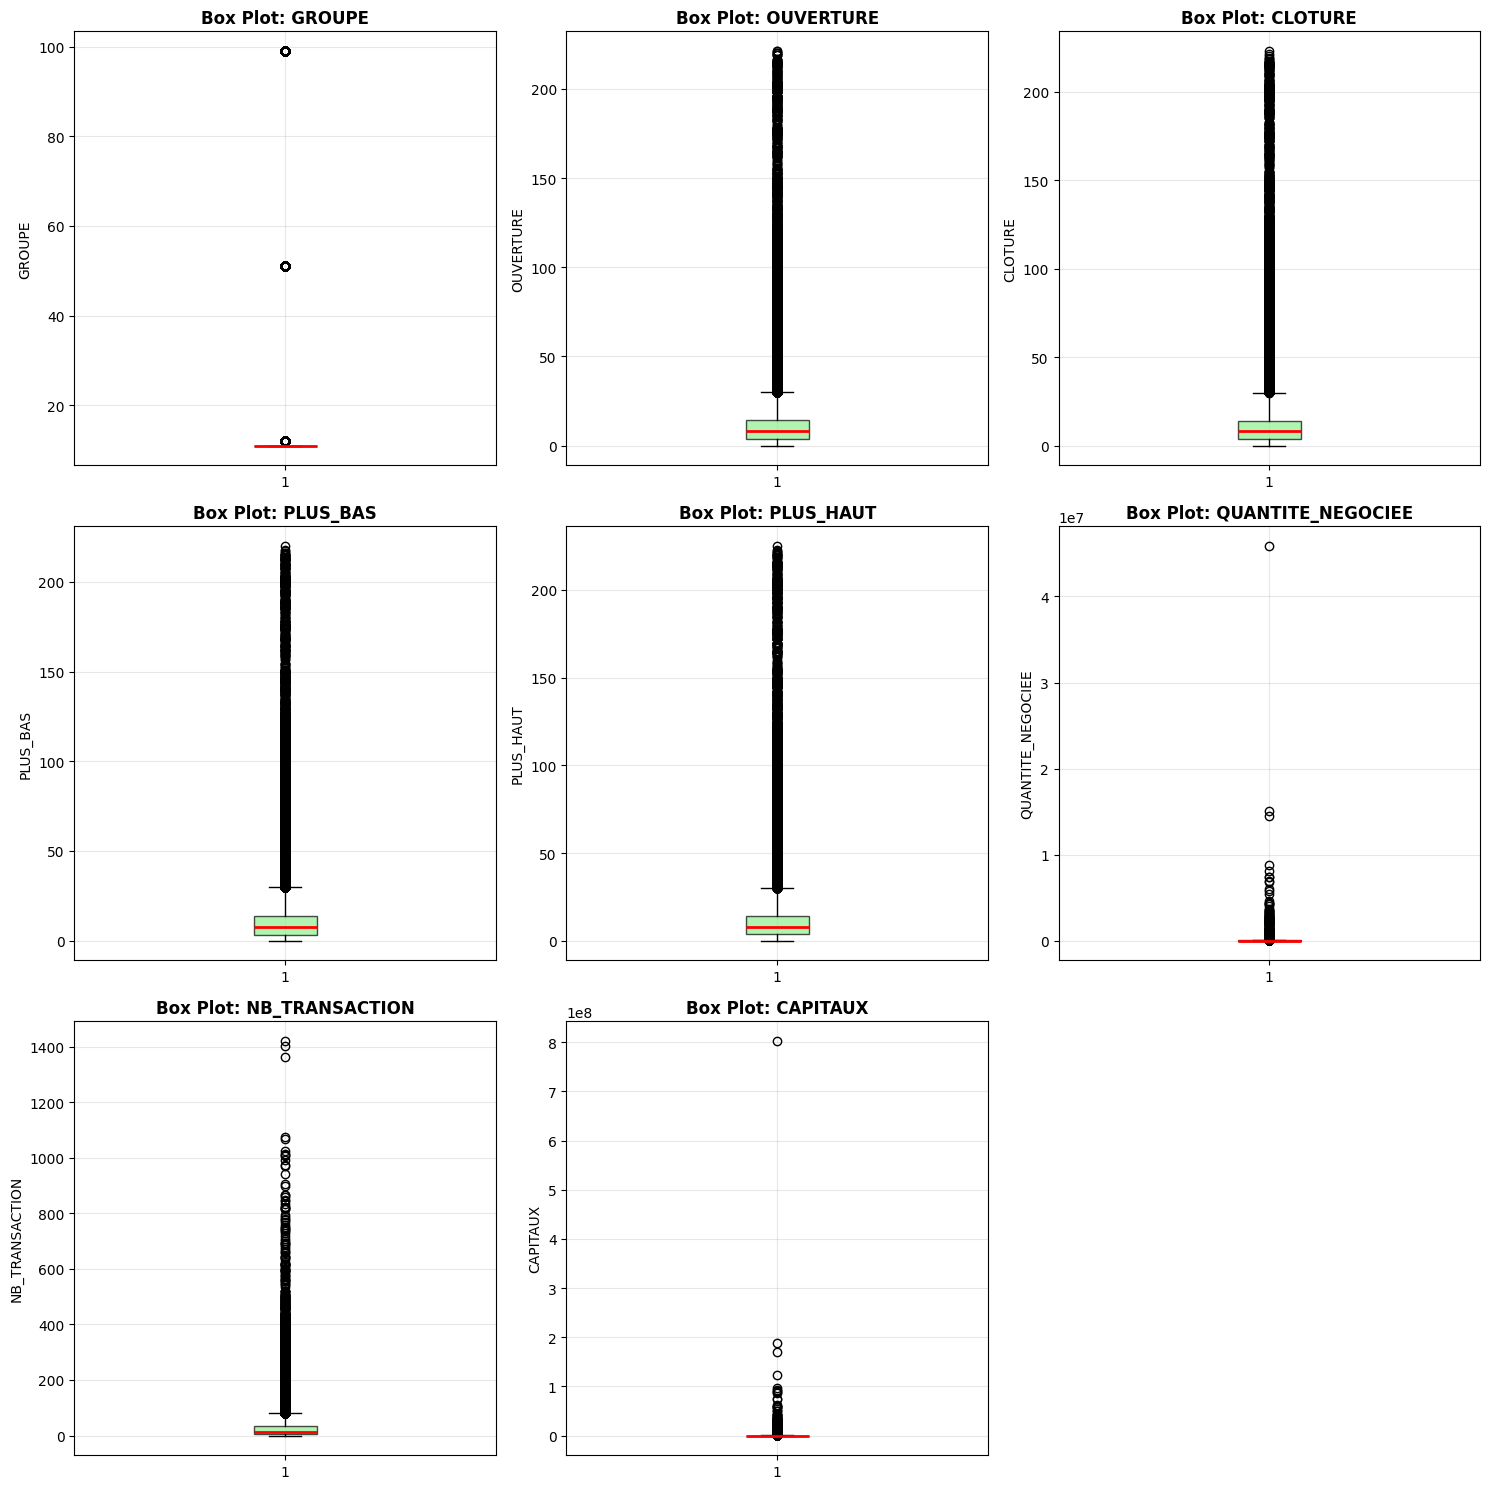


OUTLIER STATISTICS (IQR Method)

GROUPE:
  Lower bound: 11.00
  Upper bound: 11.00
  Number of outliers: 12,942 (13.46%)

OUVERTURE:
  Lower bound: -12.10
  Upper bound: 29.98
  Number of outliers: 8,107 (8.43%)

CLOTURE:
  Lower bound: -12.00
  Upper bound: 30.12
  Number of outliers: 8,201 (8.53%)

PLUS_BAS:
  Lower bound: -12.72
  Upper bound: 29.68
  Number of outliers: 8,009 (8.33%)

PLUS_HAUT:
  Lower bound: -11.98
  Upper bound: 30.23
  Number of outliers: 8,240 (8.57%)

QUANTITE_NEGOCIEE:
  Lower bound: -12710.75
  Upper bound: 22459.25
  Number of outliers: 11,745 (12.21%)

NB_TRANSACTION:
  Lower bound: -40.00
  Upper bound: 80.00
  Number of outliers: 7,666 (7.97%)

CAPITAUX:
  Lower bound: -99205.81
  Upper bound: 174544.80
  Number of outliers: 11,803 (12.27%)


In [50]:
# Box plots for outlier detection
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].boxplot(dataset[col].dropna(), vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightgreen', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'Box Plot: {col}', fontweight='bold')
        axes[idx].set_ylabel(col)
        axes[idx].grid(alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate outliers using IQR method
    print("\n" + "=" * 60)
    print("OUTLIER STATISTICS (IQR Method)")
    print("=" * 60)
    
    for col in numeric_cols:
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataset[(dataset[col] < lower_bound) | (dataset[col] > upper_bound)][col]
        
        print(f"\n{col}:")
        print(f"  Lower bound: {lower_bound:.2f}")
        print(f"  Upper bound: {upper_bound:.2f}")
        print(f"  Number of outliers: {len(outliers):,} ({(len(outliers)/len(dataset))*100:.2f}%)")
else:
    print("No numeric columns to plot.")

CORRELATION MATRIX


,GROUPE,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
GROUPE,1.000000,-0.166735,-0.168955,-0.162425,-0.168610,0.018228,0.003972,-0.008786
OUVERTURE,-0.166735,1.000000,0.993659,0.990307,0.994709,-0.024671,0.040514,0.017965
CLOTURE,-0.168955,0.993659,1.000000,0.985947,0.999093,-0.025348,0.036400,0.017698
PLUS_BAS,-0.162425,0.990307,0.985947,1.000000,0.985322,-0.023102,0.050463,0.018744
PLUS_HAUT,-0.168610,0.994709,0.999093,0.985322,1.000000,-0.025249,0.037719,0.017752
QUANTITE_NEGOCIEE,0.018228,-0.024671,-0.025348,-0.023102,-0.025249,1.000000,0.214229,0.876364
NB_TRANSACTION,0.003972,0.040514,0.036400,0.050463,0.037719,0.214229,1.000000,0.084175
CAPITAUX,-0.008786,0.017965,0.017698,0.018744,0.017752,0.876364,0.084175,1.000000


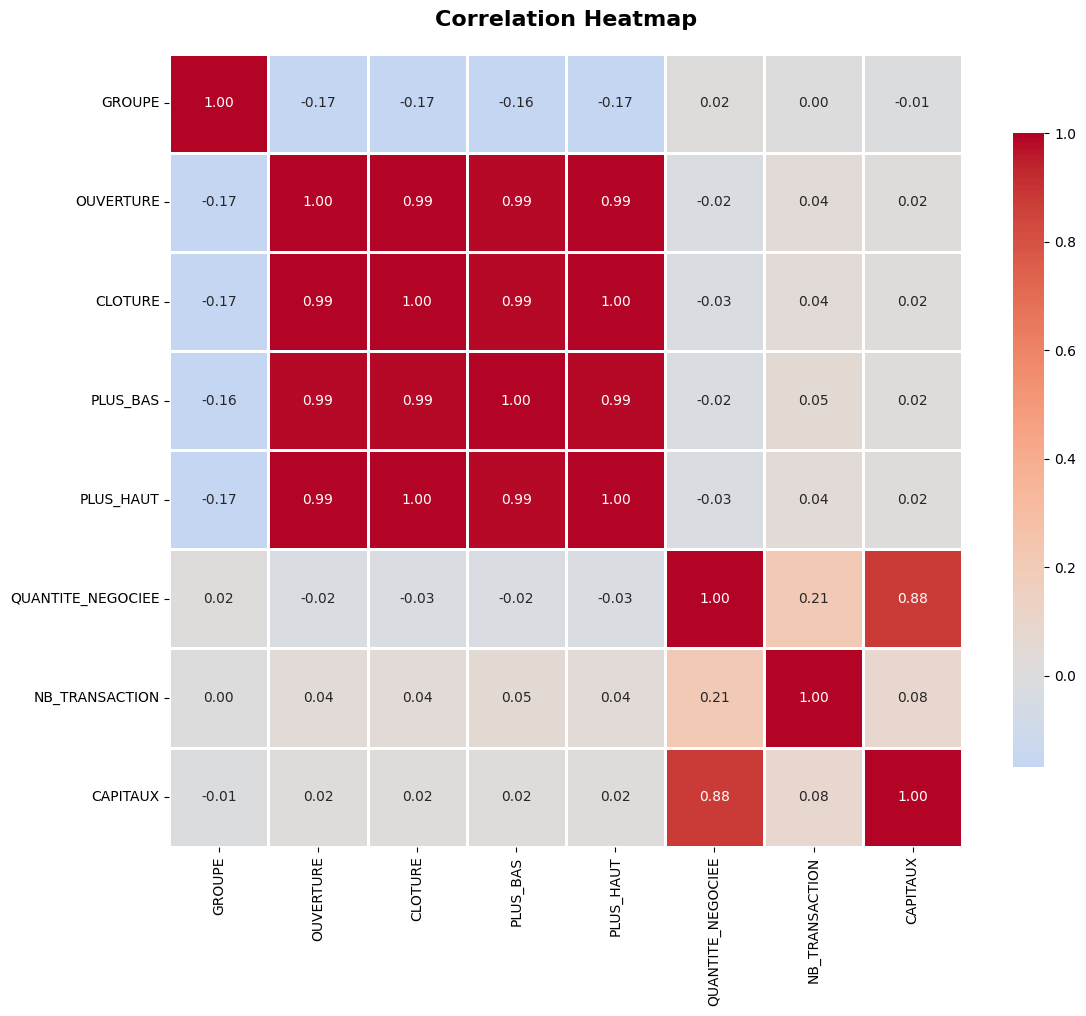


HIGHLY CORRELATED PAIRS (|correlation| > 0.7)
OUVERTURE <-> CLOTURE: 0.994
OUVERTURE <-> PLUS_BAS: 0.990
OUVERTURE <-> PLUS_HAUT: 0.995
CLOTURE <-> PLUS_BAS: 0.986
CLOTURE <-> PLUS_HAUT: 0.999
PLUS_BAS <-> PLUS_HAUT: 0.985
QUANTITE_NEGOCIEE <-> CAPITAUX: 0.876


In [51]:
# Correlation matrix for numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    correlation_matrix = dataset[numeric_cols].corr()
    
    print("=" * 60)
    print("CORRELATION MATRIX")
    print("=" * 60)
    display(correlation_matrix)
    
    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    print("\n" + "=" * 60)
    print("HIGHLY CORRELATED PAIRS (|correlation| > 0.7)")
    print("=" * 60)
    
    # Get correlation pairs
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    if corr_pairs:
        for pair in corr_pairs:
            print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
    else:
        print("No highly correlated pairs found.")
else:
    print("Not enough numeric columns for correlation analysis.")

In [52]:
# Comprehensive data quality report
print("=" * 70)
print("COMPREHENSIVE DATA QUALITY SUMMARY")
print("=" * 70)

quality_report = pd.DataFrame({
    'Column': dataset.columns,
    'Data_Type': [dataset[col].dtype for col in dataset.columns],
    'Non_Null_Count': [dataset[col].notna().sum() for col in dataset.columns],
    'Null_Count': [dataset[col].isna().sum() for col in dataset.columns],
    'Null_Percentage': [(dataset[col].isna().sum() / len(dataset)) * 100 for col in dataset.columns],
    'Unique_Values': [dataset[col].nunique() for col in dataset.columns],
    'Cardinality': [dataset[col].nunique() / len(dataset) * 100 for col in dataset.columns]
})

print("\nData Quality Report:")
display(quality_report)

print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)
print(f"✓ Total Rows: {len(dataset):,}")
print(f"✓ Total Columns: {len(dataset.columns)}")
print(f"✓ Total Missing Values: {dataset.isnull().sum().sum():,}")
print(f"✓ Total Duplicate Rows: {dataset.duplicated().sum():,}")
print(f"✓ Memory Usage: {dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"✓ Numeric Columns: {len(dataset.select_dtypes(include=[np.number]).columns)}")
print(f"✓ Categorical Columns: {len(dataset.select_dtypes(include=['object']).columns)}")
print(f"✓ Date Columns: {len(dataset.select_dtypes(include=['datetime64']).columns)}")

print("\n" + "=" * 70)
print("EDA COMPLETE!")
print("=" * 70)

COMPREHENSIVE DATA QUALITY SUMMARY

Data Quality Report:


,Column,Data_Type,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values,Cardinality
0,SEANCE,datetime64[ns],96159,0,0.0,2507,2.607140
1,GROUPE,Int64,96159,0,0.0,4,0.004160
2,CODE,string[python],96159,0,0.0,41,0.042638
3,VALEUR,string[python],96159,0,0.0,41,0.042638
4,OUVERTURE,float64,96159,0,0.0,5587,5.810169
5,CLOTURE,float64,96159,0,0.0,5628,5.852806
6,PLUS_BAS,float64,96159,0,0.0,5517,5.737372
7,PLUS_HAUT,float64,96159,0,0.0,5464,5.682255
8,QUANTITE_NEGOCIEE,Int64,96159,0,0.0,27359,28.451835
9,NB_TRANSACTION,Int64,96159,0,0.0,551,0.573009



KEY INSIGHTS
✓ Total Rows: 96,159
✓ Total Columns: 11
✓ Total Missing Values: 0
✓ Total Duplicate Rows: 0
✓ Memory Usage: 20.54 MB
✓ Numeric Columns: 8
✓ Categorical Columns: 0
✓ Date Columns: 1

EDA COMPLETE!
